# Twitter Sentiment Analysis for the word rugby

## Research Understanding Phase

Brief of the project was to acquire at least a years worth of Twitter data, having first tried to use snsscrape to acquire twitter data and having failed the decision was taken to use the archive.org and its historical twitter data. 

The archive presented its own difficulties, initially it was easy to write a code snippet to download a range of zip and tar files containing archived twitter data, however the speed of download was very slow by modenr standards, it was suspected that the archive.org throttled file downloads, to test this another download was initiated and the speed of the download compared, both downloads were happening at the same speed, having seen this multiple copies of the download code were setup to run at the same time. The initial code used can be seen in the file DownloadTwitterData.ipynb. 

However even splitting the download code into multiple notebooks proved to be very slow, an experiment was made to see how the download would work if the code was converted into a pyhton file, this experiment proved to be more successful, the pyhton file showed up to 3 times as fast at downloading a file, the code can be found in the file getTwitterdata.py; multiple copies of this file were created each with different dates ranges, and the files were set to copying files from the archive.org. 

A final experiment was tried, an Azure account was setup using free Azure student credits, then using the Azure software development kit, a python file was written that copied from the Archive.org into Azure blob storage directly, this proved to be the quickest method at getting files from the archive.org. Once the files were in blob stroage, Azure data explorer was used to download the files to a computer hard drive. The down side to this method is that it cost money, all of the free credits were used up in the copying from archive.org and in storage costs for the Azure blob storage. The account and the blob storage are no longer accessible unless credit is added to the account. This meant that only the files downloaded from Azure are available to the project.  One other issue with using this method to copy files was that the archive.org uses url redirects and the python package beautifulsoup was needed to find the ulitmate destination url for each zip and tar file. 

<code> 
    baseurl = "https://archive.org/download/archiveteam-twitter-stream-" + str_Year + '-' + str_Month  
    
    r = requests.get(baseurl)
    
    soup = BeautifulSoup(r.content)
    
    soup = soup.find('table')
    
    soup = soup.find_all('a')
    
    for element in soup:
    
        dest = 'E:/TwitterStream'
    
        lnkurl = element.get('href') 
            
</code>

In [ ]:
from urllib import request as rq
import pandas as pd
import os
from datetime import datetime as dt
import calendar
from bs4 import BeautifulSoup # for web scraping
import requests # for web scraping


In [ ]:
year = {2021, 2022}

for y in year:
    if y == 2021:
        month = range(1, 13, 1)
    else:
        month = range(1, 12, 1)
       
    for m in month:
        str_Year = str(y)
        if m < 10:
            str_Month = '0' + str(m)
        else:
            str_Month = str(m)

        baseurl = "https://archive.org/download/archiveteam-twitter-stream-" + str_Year + '-' + str_Month

# https://archive.org/download/archiveteam-twitter-stream-2021-06/twitter-stream-2021-06-14.zip
        # resorted to web scraping because there are too many variables to statically code for. 
        r = requests.get(baseurl)
        soup = BeautifulSoup(r.content)
        soup = soup.find('table')
        soup = soup.find_all('a')
        for element in soup:
            dest = 'E:/TwitterStream'
            lnkurl = element.get('href')
            # only download the files that are zip or tar 
            if lnkurl.endswith('.zip') or lnkurl.endswith('.tar'):
                dest =  dest + '/' + lnkurl
                lnkurl = baseurl + '/' + lnkurl
                print('Downloading: ' + lnkurl)
                
                if os.path.exists(dest):
                    print('File exists: ' + dest)
                    continue
                else:
                # download the file
                    try:
                        rq.urlretrieve(lnkurl, dest)
                    except:
                        print('Error: ' + lnkurl)
                        continue
                print('Downloaded: ' + lnkurl)
        

### Start of Big Data - MongoDB chosen 

The next step was to understand how the files were archived, the zip and tar files had different structures with the zip files having multiple folders in their structure, a brute force method was adapted to get the data out of the files and into a MongoDB database. 

MongoDB was chosen as the destination because of the outcome of Yahoo Cloud Serving Benchmark (YCSB) results seen below (citation)

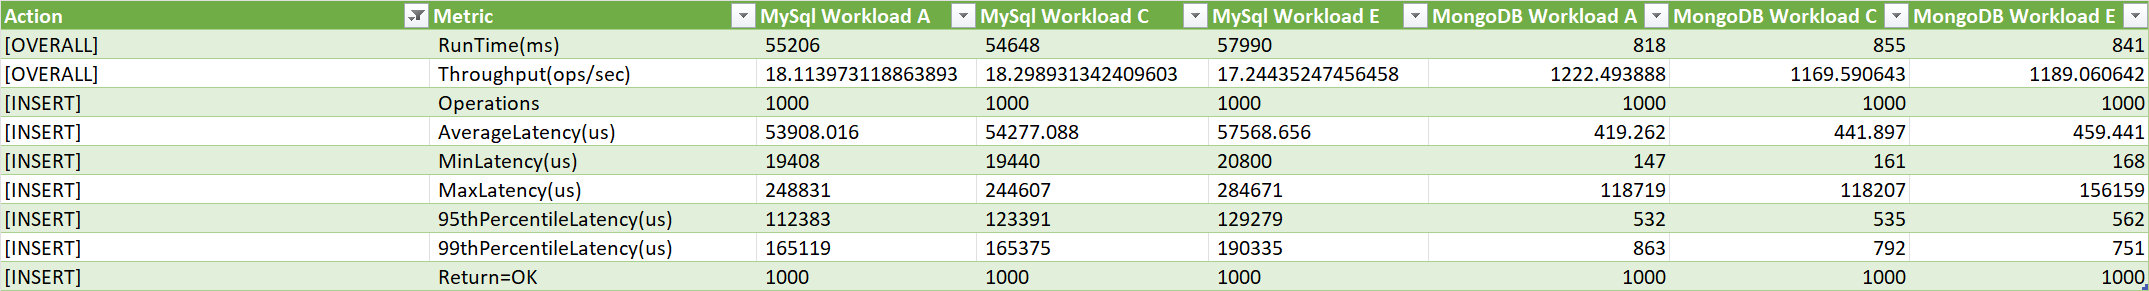


Here we can see the results of a comparison of MongoDB and MySQL over 3 different work loads, in all of them MongoDB comes out best, with the shortest runtimes and highest throughputs accross all three work loads. The workloads were chosen to mimic the work that would be happening during this project, work load A gives the results of an update heavy proccess, with 50% read and write operations, this was measured because it would mimic the intial pahase of the project, where data would be written to the database and at the same time data discovery and querying would be started. Workload C is a read only work load, and was chosen because once all of the data had been loaded then read times would be become critical for the project. Work load E was chosen as it mimics how a social network is organised and it was assumed that following tweets and retweets might be part of the analysis of the data.  

### Data gathering 

Once the files were downloading the extraction phase was started, as the files were on a Windows drive external to the Linux VM, a brute force method was used to read the files and iterate through their structures until the JSON snippets were found, then each JSON snippet was read and queried for the word 'Rugby' and snippets that contained the subject were inserted into the MongoDB.
Below is the function that was used to query the JSON objects extracted from the compressed files, and each line that contained the subject word was inserted into the MongoDB

<code>
def loadtoMongo(contents, subject):
    
    import pymongo
    client = pymongo.MongoClient("localhost", 27017)
    db = client.twitter
    db.tweets
    for line in contents:
        try:
            
            # filter the data for my subject
            fltrData = re.search(r'\b{}\b'.format(subject), line.lower())

            if fltrData:
                try:
                    data = json.loads(line)
                    #data.show()
                    #if the subject is found we write into hadoop
                    db.tweets.insert_one(data)
                except KeyError as e:
                    #print("KeyError encountered", {e}) # error is encountered mainly due to deleted tweets 
                    #print(line)
                    continue
        except json.decoder.JSONDecodeError as e:
            print("Error encountered at line: ", {e})
            continue
</code>

Below is an screenshot of the process at work, in the image we can see the size of MongoDB increasing, in the other command window we can multiple connections being opened and closed as the notebook cell is running. To speed up the extraction and loading of data from the shared drive into MongoDB, multiple copies of the notebook were created and each had different ranges in them so that multiple files were being processed at the same time. 

![Alt text](SampleTweets/Loading%20Tweets%20Into%20Mongo%20DB.png)

At this stage a decsion was taken to extract any and all lines that had the subject word in them, this was done because it would be easier to query for tweets with the subject word in tweet text in the next phase of the project using PySpark; it was also deemed quicker to query the entire tweet in one line rather than query subsections of a tweet. 

## Data Understanding Phase

With the tweets in MongoDB all work moved directly onto the Linux VM, the PySpark instance on the virtual machine was connected to the MongoDB and the database was queried. The first part was to understand was the structure of a tweet, once the strucuture was visualised by the print schema method, a temporary pySpaRK SQL view was created and then some preliminary data was queired from it. 


In [ ]:
#Connect Spark to Mongo DB

import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars "/usr/local/spark/jars/mongo-spark-connector_2.12-3.0.2.jar,/usr/local/spark/jars/mongo-java-driver-3.12.9.jar" pyspark-shell'

One issue that was over come was that pySpark tries a number  of shortcuts, one of these is the inferschema is set to read only a certain number of rows and infer the data strtucture from these rows, this caused issues with the query when we went to read the entire database of data, as the inference had chosen some of the fileds incorrectly, the fix for this was to set the inferschema to false, this made spark read the entire database and not infer the values of fields from the first set of fields. 

In [ ]:
from pyspark.sql import SparkSession
# fix read bug, basically turn off sampling
spark = SparkSession.builder.appName("TwitterMongo") \
.config("spark.mongodb.input.database", "mongodb://localhost:27017/twitter") \
.config("spark.mongodb.input.uri", "mongodb://localhost:27017/twitter.tweets") \
.config("spark.mongodb.read.sql.inferSchema.mapTypes.enabled", "FALSE") \
.config("spark.mongodb.output.uri","mongodb://localhost:27017/twitter.tweets").getOrCreate()

### Create the Session

And load all of the Twitter data in MongoDB

Print out the twitter tweet schema

In [ ]:
# create a spark session
spark = SparkSession \
.builder \
.master("local") \
.appName("ABC") \
.config("spark.driver.memory", "15g") \
.config("spark.mongodb.read.connection.uri", "mongodb://localhost:27017/twitter") \
.config("spark.mongodb.write.connection.uri", "mongodb://localhost:27017/twitter") \
.config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector:2.12-3.0.2') \
.getOrCreate()
# read data from mongodb collection "questions" into a dataframe "df"
df = spark.read \
.format("com.mongodb.spark.sql.DefaultSource") \
.option("uri", "mongodb://localhost:27017/twitter") \
.option("database", "twitter") \
.option("collection", "tweets") \
.load()
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- contributors: void (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- type: string (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: integer (containsNull = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |    |-- title: string (nullable = true)
 |    |    |    |-- description: string (nullable = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |-- media_url: string (nullable = true)
 |    |    |    |-- media_url_https: string (nullable = true)
 |    |    |    |-- sizes: struct (nullable = true)
 |    |    |    |    |-- large: struct (nullable = true)
 |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |-- medium: struct (nullable = true)
 |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |-- small: struct (nullable = true)
 |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |-- source_status_id: long (nullable = true)
 |    |    |    |-- source_status_id_str: string (nullable = true)
 |    |    |    |-- source_user_id: long (nullable = true)
 |    |    |    |-- source_user_id_str: string (nullable = true)
 |    |    |    |-- type: string (nullable = true)
 |    |    |    |-- url: string (nullable = true)
 |    |-- symbols: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: integer (containsNull = true)
 |    |-- urls: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: integer (containsNull = true)
 |    |-- user_mentions: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- screen_name: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: integer (containsNull = true)
 |-- extended_entities: struct (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |    |-- title: string (nullable = true)
 |    |    |    |-- description: string (nullable = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |-- media_url: string (nullable = true)
 |    |    |    |-- media_url_https: string (nullable = true)
 |    |    |    |-- sizes: struct (nullable = true)
 |    |    |    |    |-- large: struct (nullable = true)
 |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |-- medium: struct (nullable = true)
 |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |-- small: struct (nullable = true)
 |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |-- source_status_id: long (nullable = true)
 |    |    |    |-- source_status_id_str: string (nullable = true)
 |    |    |    |-- source_user_id: long (nullable = true)
 |    |    |    |-- source_user_id_str: string (nullable = true)
 |    |    |    |-- type: string (nullable = true)
 |    |    |    |-- url: string (nullable = true)
 |    |    |    |-- video_info: struct (nullable = true)
 |    |    |    |    |-- aspect_ratio: array (nullable = true)
 |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |-- duration_millis: integer (nullable = true)
 |    |    |    |    |-- variants: array (nullable = true)
 |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |-- bitrate: integer (nullable = true)
 |    |    |    |    |    |    |-- content_type: string (nullable = true)
 |    |    |    |    |    |    |-- url: string (nullable = true)
 |-- extended_tweet: struct (nullable = true)
 |    |-- display_text_range: array (nullable = true)
 |    |    |-- element: integer (containsNull = true)
 |    |-- entities: struct (nullable = true)
 |    |    |-- hashtags: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- text: string (nullable = true)
 |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |-- media: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |    |-- title: string (nullable = true)
 |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |-- media_url: string (nullable = true)
 |    |    |    |    |-- media_url_https: string (nullable = true)
 |    |    |    |    |-- sizes: struct (nullable = true)
 |    |    |    |    |    |-- large: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- medium: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- small: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |-- source_status_id: long (nullable = true)
 |    |    |    |    |-- source_status_id_str: string (nullable = true)
 |    |    |    |    |-- source_user_id: long (nullable = true)
 |    |    |    |    |-- source_user_id_str: string (nullable = true)
 |    |    |    |    |-- type: string (nullable = true)
 |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |    |-- video_info: struct (nullable = true)
 |    |    |    |    |    |-- aspect_ratio: array (nullable = true)
 |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |    |-- duration_millis: integer (nullable = true)
 |    |    |    |    |    |-- variants: array (nullable = true)
 |    |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |    |-- bitrate: integer (nullable = true)
 |    |    |    |    |    |    |    |-- content_type: string (nullable = true)
 |    |    |    |    |    |    |    |-- url: string (nullable = true)
 |    |    |-- urls: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |-- user_mentions: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- screen_name: string (nullable = true)
 |    |    |    |    |-- name: string (nullable = true)
 |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |-- extended_entities: struct (nullable = true)
 |    |    |-- media: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |    |-- title: string (nullable = true)
 |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |-- media_url: string (nullable = true)
 |    |    |    |    |-- media_url_https: string (nullable = true)
 |    |    |    |    |-- sizes: struct (nullable = true)
 |    |    |    |    |    |-- large: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- medium: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- small: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |-- source_status_id: long (nullable = true)
 |    |    |    |    |-- source_status_id_str: string (nullable = true)
 |    |    |    |    |-- source_user_id: long (nullable = true)
 |    |    |    |    |-- source_user_id_str: string (nullable = true)
 |    |    |    |    |-- type: string (nullable = true)
 |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |    |-- video_info: struct (nullable = true)
 |    |    |    |    |    |-- aspect_ratio: array (nullable = true)
 |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |    |-- duration_millis: integer (nullable = true)
 |    |    |    |    |    |-- variants: array (nullable = true)
 |    |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |    |-- bitrate: integer (nullable = true)
 |    |    |    |    |    |    |    |-- content_type: string (nullable = true)
 |    |    |    |    |    |    |    |-- url: string (nullable = true)
 |    |-- full_text: string (nullable = true)
 |-- favorite_count: integer (nullable = true)
 |-- favorited: boolean (nullable = true)
 |-- filter_level: string (nullable = true)
 |-- geo: struct (nullable = true)
 |    |-- type: string (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |-- id: long (nullable = true)
 |-- id_str: string (nullable = true)
 |-- in_reply_to_screen_name: string (nullable = true)
 |-- in_reply_to_status_id: long (nullable = true)
 |-- in_reply_to_status_id_str: string (nullable = true)
 |-- in_reply_to_user_id: long (nullable = true)
 |-- in_reply_to_user_id_str: string (nullable = true)
 |-- is_quote_status: boolean (nullable = true)
 |-- lang: string (nullable = true)
 |-- place: struct (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- url: string (nullable = true)
 |    |-- place_type: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- full_name: string (nullable = true)
 |    |-- country_code: string (nullable = true)
 |    |-- country: string (nullable = true)
 |    |-- bounding_box: struct (nullable = true)
 |    |    |-- type: string (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: double (containsNull = true)
 |-- possibly_sensitive: boolean (nullable = true)
 |-- quote_count: integer (nullable = true)
 |-- quoted_status: struct (nullable = true)
 |    |-- contributors: void (nullable = true)
 |    |-- coordinates: void (nullable = true)
 |    |-- created_at: string (nullable = true)
 |    |-- display_text_range: array (nullable = true)
 |    |    |-- element: integer (containsNull = true)
 |    |-- entities: struct (nullable = true)
 |    |    |-- hashtags: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- text: string (nullable = true)
 |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |-- media: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |    |    |-- title: string (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |-- media_url: string (nullable = true)
 |    |    |    |    |-- media_url_https: string (nullable = true)
 |    |    |    |    |-- sizes: struct (nullable = true)
 |    |    |    |    |    |-- large: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- medium: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- small: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |-- source_status_id: long (nullable = true)
 |    |    |    |    |-- source_status_id_str: string (nullable = true)
 |    |    |    |    |-- source_user_id: long (nullable = true)
 |    |    |    |    |-- source_user_id_str: string (nullable = true)
 |    |    |    |    |-- type: string (nullable = true)
 |    |    |    |    |-- url: string (nullable = true)
 |    |    |-- urls: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |-- user_mentions: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- screen_name: string (nullable = true)
 |    |    |    |    |-- name: string (nullable = true)
 |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |-- extended_entities: struct (nullable = true)
 |    |    |-- media: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |    |    |-- title: string (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |-- media_url: string (nullable = true)
 |    |    |    |    |-- media_url_https: string (nullable = true)
 |    |    |    |    |-- sizes: struct (nullable = true)
 |    |    |    |    |    |-- large: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- medium: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- small: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |-- source_status_id: long (nullable = true)
 |    |    |    |    |-- source_status_id_str: string (nullable = true)
 |    |    |    |    |-- source_user_id: long (nullable = true)
 |    |    |    |    |-- source_user_id_str: string (nullable = true)
 |    |    |    |    |-- type: string (nullable = true)
 |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |    |-- video_info: struct (nullable = true)
 |    |    |    |    |    |-- aspect_ratio: array (nullable = true)
 |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |    |-- duration_millis: integer (nullable = true)
 |    |    |    |    |    |-- variants: array (nullable = true)
 |    |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |    |-- bitrate: integer (nullable = true)
 |    |    |    |    |    |    |    |-- content_type: string (nullable = true)
 |    |    |    |    |    |    |    |-- url: string (nullable = true)
 |    |-- extended_tweet: struct (nullable = true)
 |    |    |-- display_text_range: array (nullable = true)
 |    |    |    |-- element: integer (containsNull = true)
 |    |    |-- entities: struct (nullable = true)
 |    |    |    |-- hashtags: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- text: string (nullable = true)
 |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |-- media: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |    |    |    |-- title: string (nullable = true)
 |    |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |    |-- media_url: string (nullable = true)
 |    |    |    |    |    |-- media_url_https: string (nullable = true)
 |    |    |    |    |    |-- sizes: struct (nullable = true)
 |    |    |    |    |    |    |-- large: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |-- medium: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |-- small: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- source_status_id: long (nullable = true)
 |    |    |    |    |    |-- source_status_id_str: string (nullable = true)
 |    |    |    |    |    |-- source_user_id: long (nullable = true)
 |    |    |    |    |    |-- source_user_id_str: string (nullable = true)
 |    |    |    |    |    |-- type: string (nullable = true)
 |    |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |    |    |-- video_info: struct (nullable = true)
 |    |    |    |    |    |    |-- aspect_ratio: array (nullable = true)
 |    |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |    |    |-- duration_millis: integer (nullable = true)
 |    |    |    |    |    |    |-- variants: array (nullable = true)
 |    |    |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |    |    |-- bitrate: integer (nullable = true)
 |    |    |    |    |    |    |    |    |-- content_type: string (nullable = true)
 |    |    |    |    |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |-- urls: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |-- user_mentions: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- screen_name: string (nullable = true)
 |    |    |    |    |    |-- name: string (nullable = true)
 |    |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |-- extended_entities: struct (nullable = true)
 |    |    |    |-- media: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |    |    |    |-- title: string (nullable = true)
 |    |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |    |-- media_url: string (nullable = true)
 |    |    |    |    |    |-- media_url_https: string (nullable = true)
 |    |    |    |    |    |-- sizes: struct (nullable = true)
 |    |    |    |    |    |    |-- large: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |-- medium: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |-- small: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- source_status_id: long (nullable = true)
 |    |    |    |    |    |-- source_status_id_str: string (nullable = true)
 |    |    |    |    |    |-- source_user_id: long (nullable = true)
 |    |    |    |    |    |-- source_user_id_str: string (nullable = true)
 |    |    |    |    |    |-- type: string (nullable = true)
 |    |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |    |    |-- video_info: struct (nullable = true)
 |    |    |    |    |    |    |-- aspect_ratio: array (nullable = true)
 |    |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |    |    |-- duration_millis: integer (nullable = true)
 |    |    |    |    |    |    |-- variants: array (nullable = true)
 |    |    |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |    |    |-- bitrate: integer (nullable = true)
 |    |    |    |    |    |    |    |    |-- content_type: string (nullable = true)
 |    |    |    |    |    |    |    |    |-- url: string (nullable = true)
 |    |    |-- full_text: string (nullable = true)
 |    |-- favorite_count: integer (nullable = true)
 |    |-- favorited: boolean (nullable = true)
 |    |-- filter_level: string (nullable = true)
 |    |-- geo: void (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- id_str: string (nullable = true)
 |    |-- in_reply_to_screen_name: string (nullable = true)
 |    |-- in_reply_to_status_id: long (nullable = true)
 |    |-- in_reply_to_status_id_str: string (nullable = true)
 |    |-- in_reply_to_user_id: long (nullable = true)
 |    |-- in_reply_to_user_id_str: string (nullable = true)
 |    |-- is_quote_status: boolean (nullable = true)
 |    |-- lang: string (nullable = true)
 |    |-- place: struct (nullable = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- url: string (nullable = true)
 |    |    |-- place_type: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- full_name: string (nullable = true)
 |    |    |-- country_code: string (nullable = true)
 |    |    |-- country: string (nullable = true)
 |    |    |-- bounding_box: struct (nullable = true)
 |    |    |    |-- type: string (nullable = true)
 |    |    |    |-- coordinates: array (nullable = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |    |-- element: double (containsNull = true)
 |    |-- possibly_sensitive: boolean (nullable = true)
 |    |-- quote_count: integer (nullable = true)
 |    |-- quoted_status_id: long (nullable = true)
 |    |-- quoted_status_id_str: string (nullable = true)
 |    |-- reply_count: integer (nullable = true)
 |    |-- retweet_count: integer (nullable = true)
 |    |-- retweeted: boolean (nullable = true)
 |    |-- source: string (nullable = true)
 |    |-- text: string (nullable = true)
 |    |-- truncated: boolean (nullable = true)
 |    |-- user: struct (nullable = true)
 |    |    |-- contributors_enabled: boolean (nullable = true)
 |    |    |-- created_at: string (nullable = true)
 |    |    |-- default_profile: boolean (nullable = true)
 |    |    |-- default_profile_image: boolean (nullable = true)
 |    |    |-- description: string (nullable = true)
 |    |    |-- favourites_count: integer (nullable = true)
 |    |    |-- follow_request_sent: void (nullable = true)
 |    |    |-- followers_count: integer (nullable = true)
 |    |    |-- following: void (nullable = true)
 |    |    |-- friends_count: integer (nullable = true)
 |    |    |-- geo_enabled: boolean (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- is_translator: boolean (nullable = true)
 |    |    |-- lang: void (nullable = true)
 |    |    |-- listed_count: integer (nullable = true)
 |    |    |-- location: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- notifications: void (nullable = true)
 |    |    |-- profile_background_color: string (nullable = true)
 |    |    |-- profile_background_image_url: string (nullable = true)
 |    |    |-- profile_background_image_url_https: string (nullable = true)
 |    |    |-- profile_background_tile: boolean (nullable = true)
 |    |    |-- profile_banner_url: string (nullable = true)
 |    |    |-- profile_image_url: string (nullable = true)
 |    |    |-- profile_image_url_https: string (nullable = true)
 |    |    |-- profile_link_color: string (nullable = true)
 |    |    |-- profile_sidebar_border_color: string (nullable = true)
 |    |    |-- profile_sidebar_fill_color: string (nullable = true)
 |    |    |-- profile_text_color: string (nullable = true)
 |    |    |-- profile_use_background_image: boolean (nullable = true)
 |    |    |-- protected: boolean (nullable = true)
 |    |    |-- screen_name: string (nullable = true)
 |    |    |-- statuses_count: integer (nullable = true)
 |    |    |-- time_zone: void (nullable = true)
 |    |    |-- translator_type: string (nullable = true)
 |    |    |-- url: string (nullable = true)
 |    |    |-- utc_offset: void (nullable = true)
 |    |    |-- verified: boolean (nullable = true)
 |-- quoted_status_id: long (nullable = true)
 |-- quoted_status_id_str: string (nullable = true)
 |-- quoted_status_permalink: struct (nullable = true)
 |    |-- url: string (nullable = true)
 |    |-- expanded: string (nullable = true)
 |    |-- display: string (nullable = true)
 |-- reply_count: integer (nullable = true)
 |-- retweet_count: integer (nullable = true)
 |-- retweeted: boolean (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- contributors: void (nullable = true)
 |    |-- coordinates: struct (nullable = true)
 |    |    |-- type: string (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: double (containsNull = true)
 |    |-- created_at: string (nullable = true)
 |    |-- display_text_range: array (nullable = true)
 |    |    |-- element: integer (containsNull = true)
 |    |-- entities: struct (nullable = true)
 |    |    |-- hashtags: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- text: string (nullable = true)
 |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |-- media: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |    |    |-- title: string (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |-- media_url: string (nullable = true)
 |    |    |    |    |-- media_url_https: string (nullable = true)
 |    |    |    |    |-- sizes: struct (nullable = true)
 |    |    |    |    |    |-- large: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- medium: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- small: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |-- source_status_id: long (nullable = true)
 |    |    |    |    |-- source_status_id_str: string (nullable = true)
 |    |    |    |    |-- source_user_id: long (nullable = true)
 |    |    |    |    |-- source_user_id_str: string (nullable = true)
 |    |    |    |    |-- type: string (nullable = true)
 |    |    |    |    |-- url: string (nullable = true)
 |    |    |-- symbols: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- text: string (nullable = true)
 |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |-- urls: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |-- user_mentions: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- screen_name: string (nullable = true)
 |    |    |    |    |-- name: string (nullable = true)
 |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |-- extended_entities: struct (nullable = true)
 |    |    |-- media: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |    |    |-- title: string (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |-- media_url: string (nullable = true)
 |    |    |    |    |-- media_url_https: string (nullable = true)
 |    |    |    |    |-- sizes: struct (nullable = true)
 |    |    |    |    |    |-- large: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- medium: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- small: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |-- source_status_id: long (nullable = true)
 |    |    |    |    |-- source_status_id_str: string (nullable = true)
 |    |    |    |    |-- source_user_id: long (nullable = true)
 |    |    |    |    |-- source_user_id_str: string (nullable = true)
 |    |    |    |    |-- type: string (nullable = true)
 |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |    |-- video_info: struct (nullable = true)
 |    |    |    |    |    |-- aspect_ratio: array (nullable = true)
 |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |    |-- duration_millis: integer (nullable = true)
 |    |    |    |    |    |-- variants: array (nullable = true)
 |    |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |    |-- bitrate: integer (nullable = true)
 |    |    |    |    |    |    |    |-- content_type: string (nullable = true)
 |    |    |    |    |    |    |    |-- url: string (nullable = true)
 |    |-- extended_tweet: struct (nullable = true)
 |    |    |-- display_text_range: array (nullable = true)
 |    |    |    |-- element: integer (containsNull = true)
 |    |    |-- entities: struct (nullable = true)
 |    |    |    |-- hashtags: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- text: string (nullable = true)
 |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |-- media: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |    |    |    |-- title: string (nullable = true)
 |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |    |-- media_url: string (nullable = true)
 |    |    |    |    |    |-- media_url_https: string (nullable = true)
 |    |    |    |    |    |-- sizes: struct (nullable = true)
 |    |    |    |    |    |    |-- large: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |-- medium: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |-- small: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- source_status_id: long (nullable = true)
 |    |    |    |    |    |-- source_status_id_str: string (nullable = true)
 |    |    |    |    |    |-- source_user_id: integer (nullable = true)
 |    |    |    |    |    |-- source_user_id_str: string (nullable = true)
 |    |    |    |    |    |-- type: string (nullable = true)
 |    |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |    |    |-- video_info: struct (nullable = true)
 |    |    |    |    |    |    |-- aspect_ratio: array (nullable = true)
 |    |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |    |    |-- duration_millis: integer (nullable = true)
 |    |    |    |    |    |    |-- variants: array (nullable = true)
 |    |    |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |    |    |-- bitrate: integer (nullable = true)
 |    |    |    |    |    |    |    |    |-- content_type: string (nullable = true)
 |    |    |    |    |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |-- symbols: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- text: string (nullable = true)
 |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |-- urls: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |-- user_mentions: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- screen_name: string (nullable = true)
 |    |    |    |    |    |-- name: string (nullable = true)
 |    |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |-- extended_entities: struct (nullable = true)
 |    |    |    |-- media: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |    |    |    |-- title: string (nullable = true)
 |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |    |-- media_url: string (nullable = true)
 |    |    |    |    |    |-- media_url_https: string (nullable = true)
 |    |    |    |    |    |-- sizes: struct (nullable = true)
 |    |    |    |    |    |    |-- large: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |-- medium: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |-- small: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- source_status_id: long (nullable = true)
 |    |    |    |    |    |-- source_status_id_str: string (nullable = true)
 |    |    |    |    |    |-- source_user_id: integer (nullable = true)
 |    |    |    |    |    |-- source_user_id_str: string (nullable = true)
 |    |    |    |    |    |-- type: string (nullable = true)
 |    |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |    |    |-- video_info: struct (nullable = true)
 |    |    |    |    |    |    |-- aspect_ratio: array (nullable = true)
 |    |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |    |    |-- duration_millis: integer (nullable = true)
 |    |    |    |    |    |    |-- variants: array (nullable = true)
 |    |    |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |    |    |-- bitrate: integer (nullable = true)
 |    |    |    |    |    |    |    |    |-- content_type: string (nullable = true)
 |    |    |    |    |    |    |    |    |-- url: string (nullable = true)
 |    |    |-- full_text: string (nullable = true)
 |    |-- favorite_count: integer (nullable = true)
 |    |-- favorited: boolean (nullable = true)
 |    |-- filter_level: string (nullable = true)
 |    |-- geo: struct (nullable = true)
 |    |    |-- type: string (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: double (containsNull = true)
 |    |-- id: long (nullable = true)
 |    |-- id_str: string (nullable = true)
 |    |-- in_reply_to_screen_name: string (nullable = true)
 |    |-- in_reply_to_status_id: long (nullable = true)
 |    |-- in_reply_to_status_id_str: string (nullable = true)
 |    |-- in_reply_to_user_id: long (nullable = true)
 |    |-- in_reply_to_user_id_str: string (nullable = true)
 |    |-- is_quote_status: boolean (nullable = true)
 |    |-- lang: string (nullable = true)
 |    |-- place: struct (nullable = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- url: string (nullable = true)
 |    |    |-- place_type: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- full_name: string (nullable = true)
 |    |    |-- country_code: string (nullable = true)
 |    |    |-- country: string (nullable = true)
 |    |    |-- bounding_box: struct (nullable = true)
 |    |    |    |-- type: string (nullable = true)
 |    |    |    |-- coordinates: array (nullable = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |    |-- element: double (containsNull = true)
 |    |-- possibly_sensitive: boolean (nullable = true)
 |    |-- quote_count: integer (nullable = true)
 |    |-- quoted_status: struct (nullable = true)
 |    |    |-- contributors: void (nullable = true)
 |    |    |-- coordinates: void (nullable = true)
 |    |    |-- created_at: string (nullable = true)
 |    |    |-- display_text_range: array (nullable = true)
 |    |    |    |-- element: integer (containsNull = true)
 |    |    |-- entities: struct (nullable = true)
 |    |    |    |-- hashtags: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- text: string (nullable = true)
 |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |-- media: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |    |    |    |-- title: string (nullable = true)
 |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |    |-- media_url: string (nullable = true)
 |    |    |    |    |    |-- media_url_https: string (nullable = true)
 |    |    |    |    |    |-- sizes: struct (nullable = true)
 |    |    |    |    |    |    |-- large: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |-- medium: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |-- small: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- source_status_id: long (nullable = true)
 |    |    |    |    |    |-- source_status_id_str: string (nullable = true)
 |    |    |    |    |    |-- source_user_id: long (nullable = true)
 |    |    |    |    |    |-- source_user_id_str: string (nullable = true)
 |    |    |    |    |    |-- type: string (nullable = true)
 |    |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |-- urls: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |-- user_mentions: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- screen_name: string (nullable = true)
 |    |    |    |    |    |-- name: string (nullable = true)
 |    |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |-- extended_entities: struct (nullable = true)
 |    |    |    |-- media: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |    |    |    |-- title: string (nullable = true)
 |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |    |-- media_url: string (nullable = true)
 |    |    |    |    |    |-- media_url_https: string (nullable = true)
 |    |    |    |    |    |-- sizes: struct (nullable = true)
 |    |    |    |    |    |    |-- large: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |-- medium: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |-- small: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |-- source_status_id: long (nullable = true)
 |    |    |    |    |    |-- source_status_id_str: string (nullable = true)
 |    |    |    |    |    |-- source_user_id: long (nullable = true)
 |    |    |    |    |    |-- source_user_id_str: string (nullable = true)
 |    |    |    |    |    |-- type: string (nullable = true)
 |    |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |    |    |-- video_info: struct (nullable = true)
 |    |    |    |    |    |    |-- aspect_ratio: array (nullable = true)
 |    |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |    |    |-- duration_millis: integer (nullable = true)
 |    |    |    |    |    |    |-- variants: array (nullable = true)
 |    |    |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |    |    |-- bitrate: integer (nullable = true)
 |    |    |    |    |    |    |    |    |-- content_type: string (nullable = true)
 |    |    |    |    |    |    |    |    |-- url: string (nullable = true)
 |    |    |-- extended_tweet: struct (nullable = true)
 |    |    |    |-- display_text_range: array (nullable = true)
 |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |-- entities: struct (nullable = true)
 |    |    |    |    |-- hashtags: array (nullable = true)
 |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |-- text: string (nullable = true)
 |    |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |-- media: array (nullable = true)
 |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |    |    |    |    |-- title: string (nullable = true)
 |    |    |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |    |    |-- media_url: string (nullable = true)
 |    |    |    |    |    |    |-- media_url_https: string (nullable = true)
 |    |    |    |    |    |    |-- sizes: struct (nullable = true)
 |    |    |    |    |    |    |    |-- large: struct (nullable = true)
 |    |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |    |-- medium: struct (nullable = true)
 |    |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |    |-- small: struct (nullable = true)
 |    |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |-- source_status_id: long (nullable = true)
 |    |    |    |    |    |    |-- source_status_id_str: string (nullable = true)
 |    |    |    |    |    |    |-- source_user_id: long (nullable = true)
 |    |    |    |    |    |    |-- source_user_id_str: string (nullable = true)
 |    |    |    |    |    |    |-- type: string (nullable = true)
 |    |    |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |    |    |    |-- video_info: struct (nullable = true)
 |    |    |    |    |    |    |    |-- aspect_ratio: array (nullable = true)
 |    |    |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |    |    |    |-- duration_millis: integer (nullable = true)
 |    |    |    |    |    |    |    |-- variants: array (nullable = true)
 |    |    |    |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |    |    |    |-- bitrate: integer (nullable = true)
 |    |    |    |    |    |    |    |    |    |-- content_type: string (nullable = true)
 |    |    |    |    |    |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |    |-- urls: array (nullable = true)
 |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |-- user_mentions: array (nullable = true)
 |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |-- screen_name: string (nullable = true)
 |    |    |    |    |    |    |-- name: string (nullable = true)
 |    |    |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |-- extended_entities: struct (nullable = true)
 |    |    |    |    |-- media: array (nullable = true)
 |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |    |    |    |    |-- title: string (nullable = true)
 |    |    |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |    |    |-- media_url: string (nullable = true)
 |    |    |    |    |    |    |-- media_url_https: string (nullable = true)
 |    |    |    |    |    |    |-- sizes: struct (nullable = true)
 |    |    |    |    |    |    |    |-- large: struct (nullable = true)
 |    |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |    |-- medium: struct (nullable = true)
 |    |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |    |-- small: struct (nullable = true)
 |    |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |    |    |    |    |-- w: integer (nullable = true)
 |    |    |    |    |    |    |    |    |-- h: integer (nullable = true)
 |    |    |    |    |    |    |    |    |-- resize: string (nullable = true)
 |    |    |    |    |    |    |-- source_status_id: long (nullable = true)
 |    |    |    |    |    |    |-- source_status_id_str: string (nullable = true)
 |    |    |    |    |    |    |-- source_user_id: long (nullable = true)
 |    |    |    |    |    |    |-- source_user_id_str: string (nullable = true)
 |    |    |    |    |    |    |-- type: string (nullable = true)
 |    |    |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |    |    |    |-- video_info: struct (nullable = true)
 |    |    |    |    |    |    |    |-- aspect_ratio: array (nullable = true)
 |    |    |    |    |    |    |    |    |-- element: integer (containsNull = true)
 |    |    |    |    |    |    |    |-- duration_millis: integer (nullable = true)
 |    |    |    |    |    |    |    |-- variants: array (nullable = true)
 |    |    |    |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |    |    |    |-- bitrate: integer (nullable = true)
 |    |    |    |    |    |    |    |    |    |-- content_type: string (nullable = true)
 |    |    |    |    |    |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |-- full_text: string (nullable = true)
 |    |    |-- favorite_count: integer (nullable = true)
 |    |    |-- favorited: boolean (nullable = true)
 |    |    |-- filter_level: string (nullable = true)
 |    |    |-- geo: void (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- in_reply_to_screen_name: string (nullable = true)
 |    |    |-- in_reply_to_status_id: long (nullable = true)
 |    |    |-- in_reply_to_status_id_str: string (nullable = true)
 |    |    |-- in_reply_to_user_id: long (nullable = true)
 |    |    |-- in_reply_to_user_id_str: string (nullable = true)
 |    |    |-- is_quote_status: boolean (nullable = true)
 |    |    |-- lang: string (nullable = true)
 |    |    |-- place: struct (nullable = true)
 |    |    |    |-- id: string (nullable = true)
 |    |    |    |-- url: string (nullable = true)
 |    |    |    |-- place_type: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- full_name: string (nullable = true)
 |    |    |    |-- country_code: string (nullable = true)
 |    |    |    |-- country: string (nullable = true)
 |    |    |    |-- bounding_box: struct (nullable = true)
 |    |    |    |    |-- type: string (nullable = true)
 |    |    |    |    |-- coordinates: array (nullable = true)
 |    |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |-- possibly_sensitive: boolean (nullable = true)
 |    |    |-- quote_count: integer (nullable = true)
 |    |    |-- quoted_status_id: long (nullable = true)
 |    |    |-- quoted_status_id_str: string (nullable = true)
 |    |    |-- reply_count: integer (nullable = true)
 |    |    |-- retweet_count: integer (nullable = true)
 |    |    |-- retweeted: boolean (nullable = true)
 |    |    |-- source: string (nullable = true)
 |    |    |-- text: string (nullable = true)
 |    |    |-- truncated: boolean (nullable = true)
 |    |    |-- user: struct (nullable = true)
 |    |    |    |-- contributors_enabled: boolean (nullable = true)
 |    |    |    |-- created_at: string (nullable = true)
 |    |    |    |-- default_profile: boolean (nullable = true)
 |    |    |    |-- default_profile_image: boolean (nullable = true)
 |    |    |    |-- description: string (nullable = true)
 |    |    |    |-- favourites_count: integer (nullable = true)
 |    |    |    |-- follow_request_sent: void (nullable = true)
 |    |    |    |-- followers_count: integer (nullable = true)
 |    |    |    |-- following: void (nullable = true)
 |    |    |    |-- friends_count: integer (nullable = true)
 |    |    |    |-- geo_enabled: boolean (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |-- is_translator: boolean (nullable = true)
 |    |    |    |-- lang: void (nullable = true)
 |    |    |    |-- listed_count: integer (nullable = true)
 |    |    |    |-- location: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- notifications: void (nullable = true)
 |    |    |    |-- profile_background_color: string (nullable = true)
 |    |    |    |-- profile_background_image_url: string (nullable = true)
 |    |    |    |-- profile_background_image_url_https: string (nullable = true)
 |    |    |    |-- profile_background_tile: boolean (nullable = true)
 |    |    |    |-- profile_banner_url: string (nullable = true)
 |    |    |    |-- profile_image_url: string (nullable = true)
 |    |    |    |-- profile_image_url_https: string (nullable = true)
 |    |    |    |-- profile_link_color: string (nullable = true)
 |    |    |    |-- profile_sidebar_border_color: string (nullable = true)
 |    |    |    |-- profile_sidebar_fill_color: string (nullable = true)
 |    |    |    |-- profile_text_color: string (nullable = true)
 |    |    |    |-- profile_use_background_image: boolean (nullable = true)
 |    |    |    |-- protected: boolean (nullable = true)
 |    |    |    |-- screen_name: string (nullable = true)
 |    |    |    |-- statuses_count: integer (nullable = true)
 |    |    |    |-- time_zone: void (nullable = true)
 |    |    |    |-- translator_type: string (nullable = true)
 |    |    |    |-- url: string (nullable = true)
 |    |    |    |-- utc_offset: void (nullable = true)
 |    |    |    |-- verified: boolean (nullable = true)
 |    |-- quoted_status_id: long (nullable = true)
 |    |-- quoted_status_id_str: string (nullable = true)
 |    |-- quoted_status_permalink: struct (nullable = true)
 |    |    |-- url: string (nullable = true)
 |    |    |-- expanded: string (nullable = true)
 |    |    |-- display: string (nullable = true)
 |    |-- reply_count: integer (nullable = true)
 |    |-- retweet_count: integer (nullable = true)
 |    |-- retweeted: boolean (nullable = true)
 |    |-- source: string (nullable = true)
 |    |-- text: string (nullable = true)
 |    |-- truncated: boolean (nullable = true)
 |    |-- user: struct (nullable = true)
 |    |    |-- contributors_enabled: boolean (nullable = true)
 |    |    |-- created_at: string (nullable = true)
 |    |    |-- default_profile: boolean (nullable = true)
 |    |    |-- default_profile_image: boolean (nullable = true)
 |    |    |-- description: string (nullable = true)
 |    |    |-- favourites_count: integer (nullable = true)
 |    |    |-- follow_request_sent: void (nullable = true)
 |    |    |-- followers_count: integer (nullable = true)
 |    |    |-- following: void (nullable = true)
 |    |    |-- friends_count: integer (nullable = true)
 |    |    |-- geo_enabled: boolean (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- is_translator: boolean (nullable = true)
 |    |    |-- lang: void (nullable = true)
 |    |    |-- listed_count: integer (nullable = true)
 |    |    |-- location: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- notifications: void (nullable = true)
 |    |    |-- profile_background_color: string (nullable = true)
 |    |    |-- profile_background_image_url: string (nullable = true)
 |    |    |-- profile_background_image_url_https: string (nullable = true)
 |    |    |-- profile_background_tile: boolean (nullable = true)
 |    |    |-- profile_banner_url: string (nullable = true)
 |    |    |-- profile_image_url: string (nullable = true)
 |    |    |-- profile_image_url_https: string (nullable = true)
 |    |    |-- profile_link_color: string (nullable = true)
 |    |    |-- profile_sidebar_border_color: string (nullable = true)
 |    |    |-- profile_sidebar_fill_color: string (nullable = true)
 |    |    |-- profile_text_color: string (nullable = true)
 |    |    |-- profile_use_background_image: boolean (nullable = true)
 |    |    |-- protected: boolean (nullable = true)
 |    |    |-- screen_name: string (nullable = true)
 |    |    |-- statuses_count: integer (nullable = true)
 |    |    |-- time_zone: void (nullable = true)
 |    |    |-- translator_type: string (nullable = true)
 |    |    |-- url: string (nullable = true)
 |    |    |-- utc_offset: void (nullable = true)
 |    |    |-- verified: boolean (nullable = true)
 |-- source: string (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp_ms: string (nullable = true)
 |-- truncated: boolean (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- contributors_enabled: boolean (nullable = true)
 |    |-- created_at: string (nullable = true)
 |    |-- default_profile: boolean (nullable = true)
 |    |-- default_profile_image: boolean (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- favourites_count: integer (nullable = true)
 |    |-- follow_request_sent: void (nullable = true)
 |    |-- followers_count: integer (nullable = true)
 |    |-- following: void (nullable = true)
 |    |-- friends_count: integer (nullable = true)
 |    |-- geo_enabled: boolean (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- id_str: string (nullable = true)
 |    |-- is_translator: boolean (nullable = true)
 |    |-- lang: void (nullable = true)
 |    |-- listed_count: integer (nullable = true)
 |    |-- location: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- notifications: void (nullable = true)
 |    |-- profile_background_color: string (nullable = true)
 |    |-- profile_background_image_url: string (nullable = true)
 |    |-- profile_background_image_url_https: string (nullable = true)
 |    |-- profile_background_tile: boolean (nullable = true)
 |    |-- profile_banner_url: string (nullable = true)
 |    |-- profile_image_url: string (nullable = true)
 |    |-- profile_image_url_https: string (nullable = true)
 |    |-- profile_link_color: string (nullable = true)
 |    |-- profile_sidebar_border_color: string (nullable = true)
 |    |-- profile_sidebar_fill_color: string (nullable = true)
 |    |-- profile_text_color: string (nullable = true)
 |    |-- profile_use_background_image: boolean (nullable = true)
 |    |-- protected: boolean (nullable = true)
 |    |-- screen_name: string (nullable = true)
 |    |-- statuses_count: integer (nullable = true)
 |    |-- time_zone: void (nullable = true)
 |    |-- translator_type: string (nullable = true)
 |    |-- url: string (nullable = true)
 |    |-- utc_offset: void (nullable = true)
 |    |-- verified: boolean (nullable = true)

In [ ]:
# set up hadoop folder structure for exprting data later in the process

!hadoop fs -test -d /ca4 && hadoop fs -rm -f -R /ca4
!hadoop fs -mkdir /ca4


Create a spark object of the tweets held in the mongo db 

It is easier to use SQL statements and Pyspark to clean the data rather than writing queries in MongoDB

In [ ]:
df.createOrReplaceTempView("tweets")

Exploratory data analysis 

1: How many tweets in the DB all together

In [ ]:
df = spark.sql("SELECT DISTINCT id FROM tweets WHERE text LIKE '%rugby%'")
df.count()

72807

2: How many tweets by language 


In [ ]:
#pip install plotly
%pip install kaleido
import kaleido
import pyspark.pandas as ps
import plotly
dfLang = spark.sql("SELECT DISTINCT lang, CAST(count(id) AS INT) as TweetCount FROM tweets \
            WHERE text LIKE '%rugby%' \
            GROUP BY lang \
            ORDER BY TweetCount DESC LIMIT 10")
dfLang.show()

+----+----------+
|lang|TweetCount|
+----+----------+
|  en|     48892|
|  fr|      8450|
|  es|      6754|
|  ja|      4105|
| und|      1618|
|  pt|       614|
|  it|       480|
|  tl|       309|
|  ca|       274|
|  in|       251|
+----+----------+

                                                                                

In [ ]:
tempdf = ps.DataFrame(dfLang)

fig = tempdf.plot(kind='bar', x='lang', y='TweetCount')
fig.show()

fig.write_image("Images/TweetCountByLanguage.svg")
fig.write_html("Images/TweetCountByLanguage.html")

![Alt text](Images/TweetCountByLanguage.svg)

3: How many tweets by location

In [ ]:
dfLoc = spark.sql("SELECT DISTINCT user.location AS Location, CAST(count(id) AS INT) as TweetCount FROM tweets \
                   WHERE text LIKE '%rugby%' \
                   GROUP BY user.location \
                   ORDER BY TweetCount DESC LIMIT 10")
dfLoc.show()

+--------------------+----------+
|            Location|TweetCount|
+--------------------+----------+
|                null|     24804|
|     London, England|       543|
|      United Kingdom|       529|
|              France|       503|
|     Kampala, Uganda|       500|
|            Alicante|       462|
|              London|       426|
|             Ireland|       374|
|        South Africa|       348|
|Wales, United Kin...|       338|
+--------------------+----------+

In [ ]:
dfLoc = spark.sql("SELECT DISTINCT user.location AS Location, CAST(count(id) AS INT) as TweetCount FROM tweets \
                   WHERE text LIKE '%rugby%' AND user.location IS NOT Null \
                   GROUP BY user.location \
                   ORDER BY TweetCount DESC LIMIT 10")
tempdf = ps.DataFrame(dfLoc)

fig = tempdf.plot(kind='bar', x='Location', y='TweetCount')
fig.show()


fig.write_image("Images/TweetCountByuserLocation.svg")
fig.write_html("Images/TweetCountByuserLocation.html")

![Alt text](Images/TweetCountByuserLocation.svg)

Now limit the dataset to English texts and tweets with the rugby in the text

In [ ]:
dfEnTwt = spark.sql("SELECT * FROM tweets WHERE lang = 'en' AND text LIKE '%rugby%'")
dfEnTwt.createOrReplaceTempView("en_tweets")
dfEnTwt.show() # lost the output of this cell

Now how many tweets in the English language dataset

In [ ]:
dfEnTwt.count()

48892

In [ ]:
dfLoc = spark.sql("SELECT DISTINCT user.location AS Location, CAST(count(id) AS INT) as TweetCount \
                   FROM en_tweets GROUP BY user.location \
                   ORDER BY TweetCount DESC LIMIT 10")
dfLoc.show()

+--------------------+----------+
|            Location|TweetCount|
+--------------------+----------+
|                null|     15507|
|      United Kingdom|       518|
|     London, England|       514|
|     Kampala, Uganda|       467|
|              London|       410|
|             Ireland|       356|
|        South Africa|       327|
|Wales, United Kin...|       315|
|England, United K...|       301|
|Cape Town, South ...|       264|
+--------------------+----------+

In [ ]:

dfDay= spark.sql("SELECT DISTINCT CAST(substring(created_at, 27, 4) AS INT) as Year, \
          CAST(from_unixtime(unix_timestamp(substring(created_at, 5, 3), 'MMM'), 'MM') As INT) as Month, \
          CAST(substring(created_at, 9, 2) AS INT) as Day, \
          CAST(count(id) AS INT) as TweetCount \
          FROM en_tweets \
          WHERE lang = 'en' AND text LIKE '%rugby%' GROUP BY substring(created_at, 27, 4), \
          substring(created_at, 5, 3), \
          substring(created_at, 9, 2)")

dfDay.createOrReplaceTempView("tweetsByDay")

dfDay = spark.sql("SELECT CONCAT(Year, '_', Month, '_', DAY) AS Date, TweetCount  \
                    FROM tweetsByDay ORDER BY Year, Month, Day")

dfDay.show()



+---------+----------+
|     Date|TweetCount|
+---------+----------+
|2021_1_29|         1|
| 2021_2_1|        69|
| 2021_2_2|        73|
| 2021_2_3|        51|
| 2021_2_4|        67|
| 2021_2_5|        88|
| 2021_2_6|       266|
| 2021_2_7|       254|
| 2021_2_8|       139|
| 2021_2_9|       112|
|2021_2_10|        86|
|2021_2_11|        75|
|2021_2_12|        96|
|2021_2_13|       184|
|2021_2_14|       129|
|2021_2_15|        59|
|2021_2_16|        65|
|2021_2_17|        67|
|2021_2_18|        72|
|2021_2_19|       112|
+---------+----------+
only showing top 20 rows

In [ ]:
tempdf = ps.DataFrame(dfDay)

fig = tempdf.plot(kind='bar', x='Date', y='TweetCount')
fig.show()


fig.write_image("Images/TweetCountByDay.svg")
fig.write_html("Images/TweetCountByDay.html")

In [ ]:
dfWeek = spark.sql("SELECT Year, weekofyear(make_date(Year, Month, Day)) as wkofYr , SUM(TweetCount) as TweetCountbyWeek \
                   FROM tweetsByDay \
                   GROUP BY Year, weekofyear(make_date(Year, Month, Day))")

dfWeek.createOrReplaceTempView("tweetsByWeek")
dfWeek = spark.sql("SELECT Year, wkofYr, CONCAT(Year, '_', wkofYr) AS yr_wk, TweetCountbyWeek  \
                   FROM tweetsByWeek ORDER BY Year, wkofYr")
dfWeek.show()

+----+------+-------+----------------+
|Year|wkofYr|  yr_wk|TweetCountbyWeek|
+----+------+-------+----------------+
|2021|     4| 2021_4|               1|
|2021|     5| 2021_5|             868|
|2021|     6| 2021_6|             821|
|2021|     7| 2021_7|             632|
|2021|     8| 2021_8|             701|
|2021|     9| 2021_9|             645|
|2021|    10|2021_10|             721|
|2021|    11|2021_11|             869|
|2021|    12|2021_12|             800|
|2021|    13|2021_13|             616|
|2021|    14|2021_14|             381|
|2021|    17|2021_17|             378|
|2021|    18|2021_18|             595|
|2021|    19|2021_19|             488|
|2021|    20|2021_20|             496|
|2021|    21|2021_21|             461|
|2021|    22|2021_22|             420|
|2021|    23|2021_23|             404|
|2021|    24|2021_24|             509|
|2021|    25|2021_25|             472|
+----+------+-------+----------------+
only showing top 20 rows

In [ ]:
tempdf = ps.DataFrame(dfWeek)

fig = tempdf.plot(kind='bar', x='yr_wk', y='TweetCountbyWeek')
fig.show()


fig.write_image("Images/TweetCountByWeek.svg")
fig.write_html("Images/TweetCountByWeek.html")

![Alt text](Images/TweetCountByWeek.svg)

In [ ]:
# get the tweet count by month
dfMonth = spark.sql("SELECT Year, Month, SUM(TweetCount) as TweetCountbyMonth \
                     FROM tweetsByDay GROUP BY Year, Month")
dfMonth.createOrReplaceTempView("tweetsByMonth")
dfMonth = spark.sql("SELECT Year, Month, CONCAT(Year, '_', Month) AS MonthYr, TweetCountbyMonth  \
                     FROM tweetsByMonth ORDER BY Year, Month ")
dfMonth.show()

+----+-----+-------+-----------------+
|Year|Month|MonthYr|TweetCountbyMonth|
+----+-----+-------+-----------------+
|2021|    1| 2021_1|                1|
|2021|    2| 2021_2|             3022|
|2021|    3| 2021_3|             3298|
|2021|    4| 2021_4|              981|
|2021|    5| 2021_5|             2222|
|2021|    6| 2021_6|             1935|
|2021|    7| 2021_7|             2366|
|2021|    8| 2021_8|             2102|
|2021|    9| 2021_9|             2447|
|2021|   10|2021_10|             2553|
|2021|   11|2021_11|             2440|
|2021|   12|2021_12|             1880|
|2022|    1| 2022_1|              450|
|2022|    2| 2022_2|              824|
|2022|    3| 2022_3|             2605|
|2022|    4| 2022_4|             2614|
|2022|    5| 2022_5|             2487|
|2022|    6| 2022_6|             2235|
|2022|    7| 2022_7|             2844|
|2022|    8| 2022_8|             2271|
+----+-----+-------+-----------------+
only showing top 20 rows

In [ ]:
tempdf = ps.DataFrame(dfMonth)

fig = tempdf.plot(kind='bar', x='MonthYr', y='TweetCountbyMonth')
fig.show()
fig.write_image("Images/TweetCountByMonth.svg")
fig.write_html("Images/TweetCountByMonth.html")

![Alt text](Images/TweetCountByMonth.svg)

## Data Preparation Phase 

### Text clean up in pySpark 

First step done was to limit the dataset to tweet id and the tweet text

In [ ]:
#%pip install vadersentiment


In [ ]:
dfText = spark.sql("SELECT DISTINCT id, text AS text FROM en_tweets")
dfText.createOrReplaceTempView("text")
dfText.show()
dfText.count()


                                                                                
+-------------------+--------------------+
|                 id|                text|
+-------------------+--------------------+
|1444274428221734923|What a game of ru...|
|1477389703984865287|RT @labour_histor...|
|1477323861788086273|RT @rugby_sport_x...|
|1477243301812183043|RT @scarlets_rugb...|
|1430144262642061313|RT @premrugby: We...|
|1511701614725320710|RT @MattHardyJour...|
|1477194664642072577|RT @berwickrugby:...|
|1444399334578032646|RT @therugbynetwo...|
|1477681992468733955|RT @premrugby: Is...|
|1356290118911483915|English rugby can...|
|1369037166609915904|@PaulMorganrugby ...|
|1444016000375132201|RT @DalinOliver: ...|
|1444354564594016256|@liamski19 @glouc...|
|1444277217429688325|RT @ultimaterugby...|
|1429767303747489792|@DIDDLYONE @kazim...|
|1444274189133811714|RT @vacuumsealpie...|
|1356253066459230210|@George_North Lla...|
|1429855413474893824|@PDRescue @Pawpri...|
|1429821309584871427|@SkySports Wtf is...|
|1413975199750438913|RT @BobbyMcDonagh...|
+-------------------+--------------------+
only showing top 20 rows

                                                                                
48726

Count the number of words in the tweets 

In [ ]:
from pyspark.sql.functions import * 
from pyspark.sql.types import StringType, ArrayType
# heavy reliance on SQL functions in the following code

dfWord = dfText.withColumn("Word", explode(split(col("text"), ' '))).groupBy("Word").count().orderBy(desc("count"))

dfWord.show()

+-----+-----+
| Word|count|
+-----+-----+
|  the|25866|
|   RT|24751|
|rugby|24389|
|   to|16333|
|    a|14673|
|   in|11306|
|   of|11130|
|  and|10737|
|  for| 8756|
|   is| 7034|
|   on| 5671|
|    I| 5522|
|   at| 4442|
|  you| 4143|
| this| 4107|
| with| 4051|
|     | 3820|
| that| 3302|
|  are| 3197|
| from| 3192|
+-----+-----+
only showing top 20 rows

Count the number of characters including spaces

In [ ]:
dfChar = spark.sql("SELECT text, LENGTH(text) AS char FROM text ORDER BY char DESC")
dfChar.show(5)

Check for special characters i.e. Hashtags

In [ ]:
dfSpecChar = spark.sql("SELECT text, regexp_extract_all(text, '(#\\\\w+)', 1) AS Hashtags \
                        FROM text WHERE text like '%#%' ")
dfSpecChar.show()

Check for upper case 

In [ ]:
dfUpper = spark.sql("SELECT text FROM text WHERE translate(text, 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', '') = ''")
dfUpper.show()


Check for numbers 



In [ ]:
dfNum = spark.sql("SELECT text FROM text WHERE translate(text, '0123456789', '') <> text")
dfNum.show()

This check does not really advance our understanding of the data, a lot of twitter names have numbers in them

In [ ]:
dfNum.count()

Leave only text in the strings, all non alpha numeric characters are removed with the application of the regular expression 

In [ ]:

pattern = r'[^a-zA-Z0-9\s]'

dfText = spark.sql("SELECT id, text AS orignialText, text FROM text")
dfText = dfText.withColumn("text", regexp_replace('text', pattern, ''))
dfText.take(5)

In [ ]:
dfText.createOrReplaceTempView("text") # this is cleaned txt
dfText = spark.sql("SELECT id, orignialText, LOWER(TRIM(text)) AS text FROM text")

dfText.take(5)

The text variable contains only lower case text that has been trimmed, that is spaces from the start and the end of the line have been removed, and numbers have been removed. 

In [ ]:

dfText.createOrReplaceTempView("text") # this is the trimmed and lowercase txt
dfText = spark.sql("SELECT id, orignialText, text FROM text")
dfText.show(5)

Fix the spelling, didn't get it to work so I left it. 

In [ ]:
#%pip install textblob
from textblob import TextBlob

dfText = spark.sql("SELECT id, orignialText, text FROM text")
#dfText = dfText.withColumn("newtext", col(TextBlob("text").correct()))

dfText.show(5)

### Tokenize and Stem the tweets

In [ ]:
#%pip install nltk

In [ ]:
# stackoverflow ref: https://stackoverflow.com/questions/53579444

from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer
from nltk.stem.snowball import SnowballStemmer

In [ ]:
# Tokenize text
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
dfTextTok = tokenizer.transform(dfText).select("text","tokens")
dfText = dfText.join(dfTextTok, on=['text'], how='left_outer')
dfText.show(5)

In [ ]:
# Remove stopwords
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered")
dfText = remover.transform(dfText).select("id", "text","tokens","filtered")
dfText.show(5)

Now recheck for the most common words and decide if they need to be removed 

In [ ]:
#dfWord = dfText.withColumn("Word", explode(split(col("filtered"), ' '))).groupBy("Word").count().orderBy(desc("count").limit(10))

#dfWord.show()

Now look at rare words 

In [ ]:
#dfWord = dfText.withColumn("Word", explode(split(col("text"), ' '))).groupBy("Word").count().orderBy(asc("count").limit(10))

#dfWord.show()

Decided to stem the words as per this page https://stackoverflow.com/questions/53579444

In [ ]:
# stem the words
stemmer = SnowballStemmer(language='english')
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
dfText = dfText.withColumn("filtered_stemmed", stemmer_udf("filtered"))
dfText.show(5)

In [ ]:
# Filter out short words
filterShortWords = udf(lambda row: [x for x in row if len(x) >= 4], ArrayType(StringType()))
dfText = dfText.withColumn("filtered_stemmed", filterShortWords("filtered_stemmed"))

dfText.show(5)


In [ ]:
dfText.count()

Output the cleaned text into a parquet file for ease of transfer between machines.



In [ ]:
# clean up hadoop outplut location
!hadoop fs -rm -R -f /ca4/rugby_twitter.parquet

# write it to hadoop
dfText.coalesce(1).write.parquet("/ca4/rugby_twitter.parquet")

# check if the file was written out
!hadoop fs -ls /ca4/rugby_twitter.parquet

# output to the project folder 
!hadoop fs -get '/ca4/rugby_twitter.parquet' './'

In [ ]:
# select tweet id, geo, lang, quoted_status,quoted_status.geo 
# Having a look at some the data
dfdashboard = spark.sql("SELECT DISTINCT id, created_at, CAST(substring(created_at, 27, 4) AS INT) as Year, \
                    CAST(from_unixtime(unix_timestamp(substring(created_at, 5, 3), 'MMM'), 'MM') As INT) as Month, \
                    CAST(substring(created_at, 9, 2) AS INT) as Day,\
                    weekofyear(make_date(CAST(substring(created_at, 27, 4) AS INT),\
                    CAST(from_unixtime(unix_timestamp(substring(created_at, 5, 3), 'MMM'), 'MM') As INT),\
                    CAST(substring(created_at, 9, 2) AS INT))) as wkofYr, \
                    quote_count, reply_count, retweet_count, favorite_count, \
                    lang  \
                    FROM en_tweets")

dfdashboard.show()


In [ ]:
dfdashboard.printSchema()

In [ ]:
display(dfdashboard.count())
!hadoop fs -rm -R -f /ca4/dashboard.parquet
dfdashboard.coalesce(1).write.parquet("/ca4/dashboard.parquet")

# check if the file was written out
!hadoop fs -ls /ca4/dashboard.parquet


# output to the project folder 
!hadoop fs -get '/ca4/dashboard.parquet' './'

In [ ]:
## sentiment analysis ref: https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/?ref=lbp
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# function to print sentiments
# of the sentence.
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
    return sentiment_dict['compound']


#https://www.geeksforgeeks.org/python-sentiment-analysis-using-affin
#!pip install afinn

def afinn_scores(sentence):
    afn = Afinn(language = 'en')
    score = afn.score(sentence)
    return score


## Building the model 

In [ ]:
pdfText = dfText.toPandas()
type(pdfText)
import nltk
#nltk.download('punkt')

pdfText.head()

In [ ]:
pdfText['txbSentiment'] = pdfText['text'].apply(lambda x: TextBlob(x).sentiment[0])


pdfText[['text', 'txbSentiment']].head()


In [ ]:
pdfText['vaderSentiment'] = pdfText['text'].apply(lambda x: sentiment_scores(x))

In [ ]:
pdfText[['text', 'txbSentiment', 'vaderSentiment']].head(20)

In [ ]:
pdfText.head()

In [ ]:
pdfText.to_csv("Data/TweetwithSentiment.csv", encoding='utf-8')

## Modeling Phase

### Start of Time Series Analysis 

Time Series predictions 

First up join the text that has been analysed for sentiment with the extra tweet information

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
tweetInfo = pd.read_parquet("dashboard.parquet/part-00000-e7c7dfd6-6303-4e5a-afd1-5b3eb99465b7-c000.snappy.parquet")
sentimentInfo = pd.read_csv("Data/TweetwithSentiment.csv")
sentimentInfo = sentimentInfo.drop(['Unnamed: 0'], axis=1)
sentimentInfo = sentimentInfo.groupby(['id']).mean()

C:\Users\stehayes\AppData\Local\Temp\ipykernel_6808\1536905551.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sentimentInfo = sentimentInfo.groupby(['id']).mean()


In [2]:
tweetInfo = pd.merge(tweetInfo , sentimentInfo, left_on='id', right_on='id', how='inner')

In [3]:
tweetInfo['CombinedSentiment'] = tweetInfo['txbSentiment'] + tweetInfo['vaderSentiment']

In [4]:
tweetInfo['LikertScale'] = tweetInfo['CombinedSentiment'].apply(lambda x: 'Very Positive' if x > 1 else ('Positive' if x > 0  else ('Neutral' if x == 0 else ('Negative' if x > -1  else 'Very Negative'))))

<AxesSubplot: title={'center': 'Tweets by Day'}, xlabel='Day'>

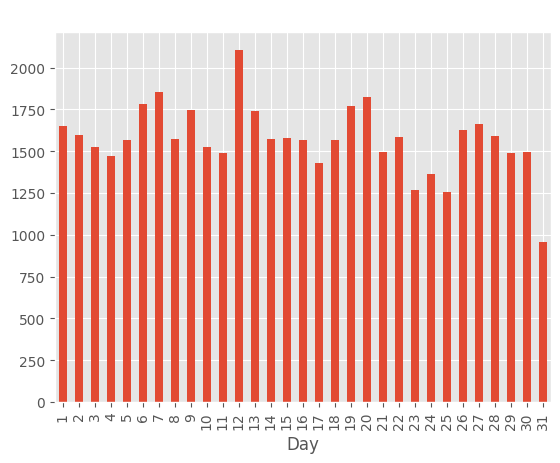

In [5]:

tweetInfo.value_counts('Day').sort_index().plot(kind='bar', title='Tweets by Day')

<AxesSubplot: title={'center': 'Tweets by Month'}, xlabel='Month'>

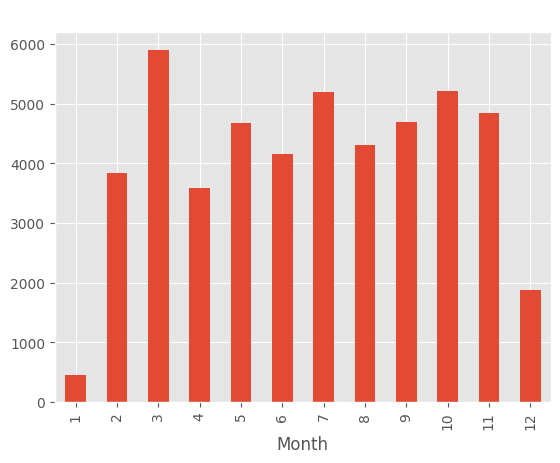

In [6]:

tweetInfo.value_counts('Month').sort_index().plot(kind='bar', title='Tweets by Month')

<AxesSubplot: title={'center': 'Tweets by Week'}, xlabel='wkofYr'>

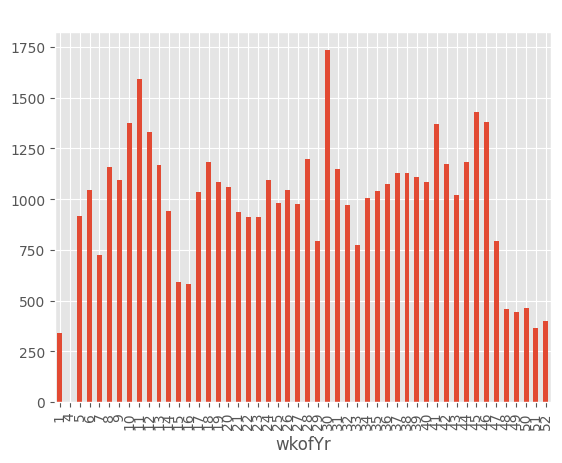

In [7]:
tweetInfo.value_counts('wkofYr').sort_index().plot(kind='bar', title='Tweets by Week')

As we can see January is missing data from a couple of weeks 
This is an issue with the data source and can't be recitified by going back to the data
The plan is too sample 1000 rows from the data frame and add them in january 
Also I am going to drop the year value as other months are missing days 

In [8]:
# use a boolean mask to filter the data
mask = (tweetInfo['Month'] != 1) & (tweetInfo['wkofYr'] > 5)
sampledData = tweetInfo[mask].sample(1200)


sampledData.loc[:, 'Month'] = 1
sampledData.loc[:, 'wkofYr'] = 0 # so the next line spreads the data evenly
sampledData['wkofYr'] = pd.to_datetime(sampledData[['Year', 'Month', 'Day']]).dt.weekofyear


C:\Users\stehayes\AppData\Local\Temp\ipykernel_6808\201084437.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  sampledData['wkofYr'] = pd.to_datetime(sampledData[['Year', 'Month', 'Day']]).dt.weekofyear


<AxesSubplot: title={'center': 'Tweets by Week'}, xlabel='wkofYr'>

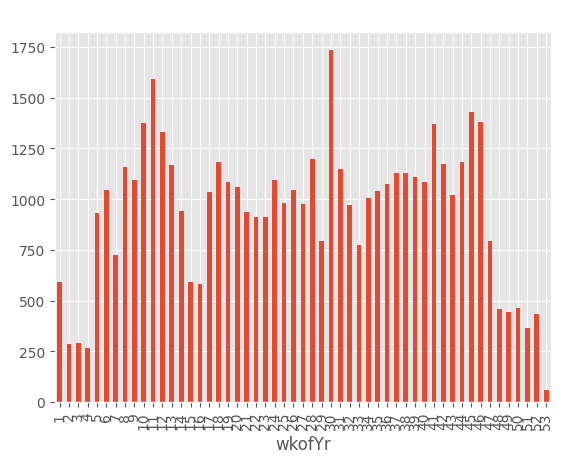

In [9]:
tweetInfo = pd.concat([sampledData, tweetInfo])
tweetInfo.value_counts('wkofYr').sort_index().plot(kind='bar', title='Tweets by Week')

Get ready for the time series model

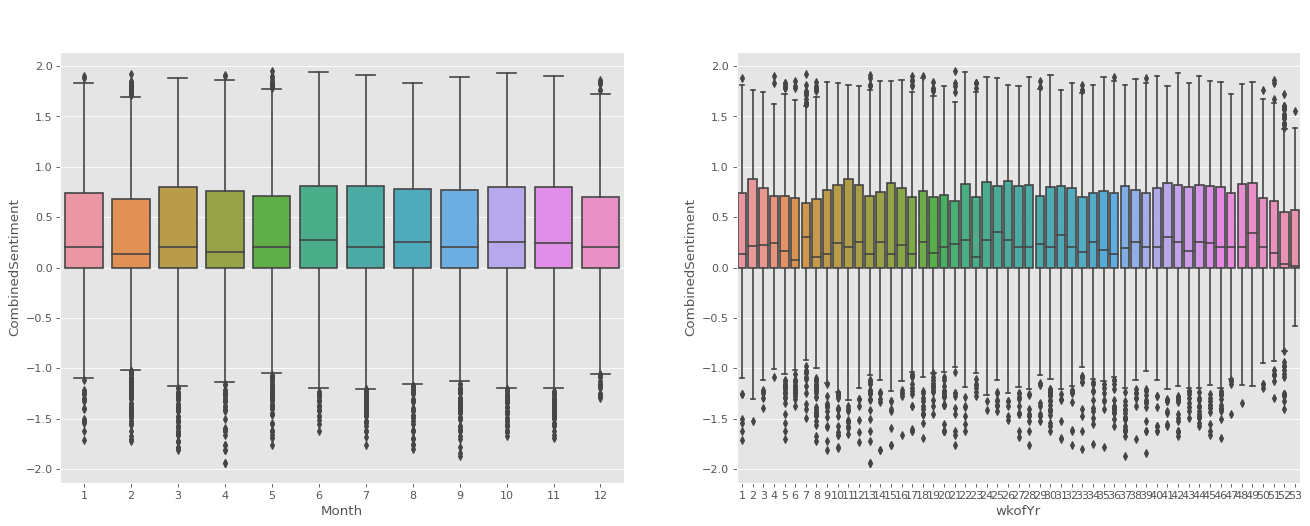

In [10]:
import seaborn as sns
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='Month', y='CombinedSentiment', data=tweetInfo, ax=axes[0])
sns.boxplot(x='wkofYr', y='CombinedSentiment', data=tweetInfo)

# Set Title
axes[0].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18); 
axes[1].set_title('Week-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
%matplotlib inline
# Create and end of week frequency
df = tweetInfo[['created_at', 'txbSentiment', 'vaderSentiment', 'CombinedSentiment']]
# the two lines below are to make sure the date is in the right format
df['date'] = pd.to_datetime(df['created_at'])
df = df.set_index('date')


C:\Users\stehayes\AppData\Local\Temp\ipykernel_6808\2423307534.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['created_at'])


In [12]:
df = df.resample('W').mean()

missing = df.isnull()
missing.head()

C:\Users\stehayes\AppData\Local\Temp\ipykernel_6808\4222316919.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample('W').mean()


,txbSentiment,vaderSentiment,CombinedSentiment
date,,,
2021-01-31 00:00:00+00:00,False,False,False
2021-02-07 00:00:00+00:00,False,False,False
2021-02-14 00:00:00+00:00,False,False,False
2021-02-21 00:00:00+00:00,False,False,False
2021-02-28 00:00:00+00:00,False,False,False


In [13]:
df = df.interpolate(method='linear', axis=0)
df.isnull().sum()

txbSentiment         0
vaderSentiment       0
CombinedSentiment    0
dtype: int64

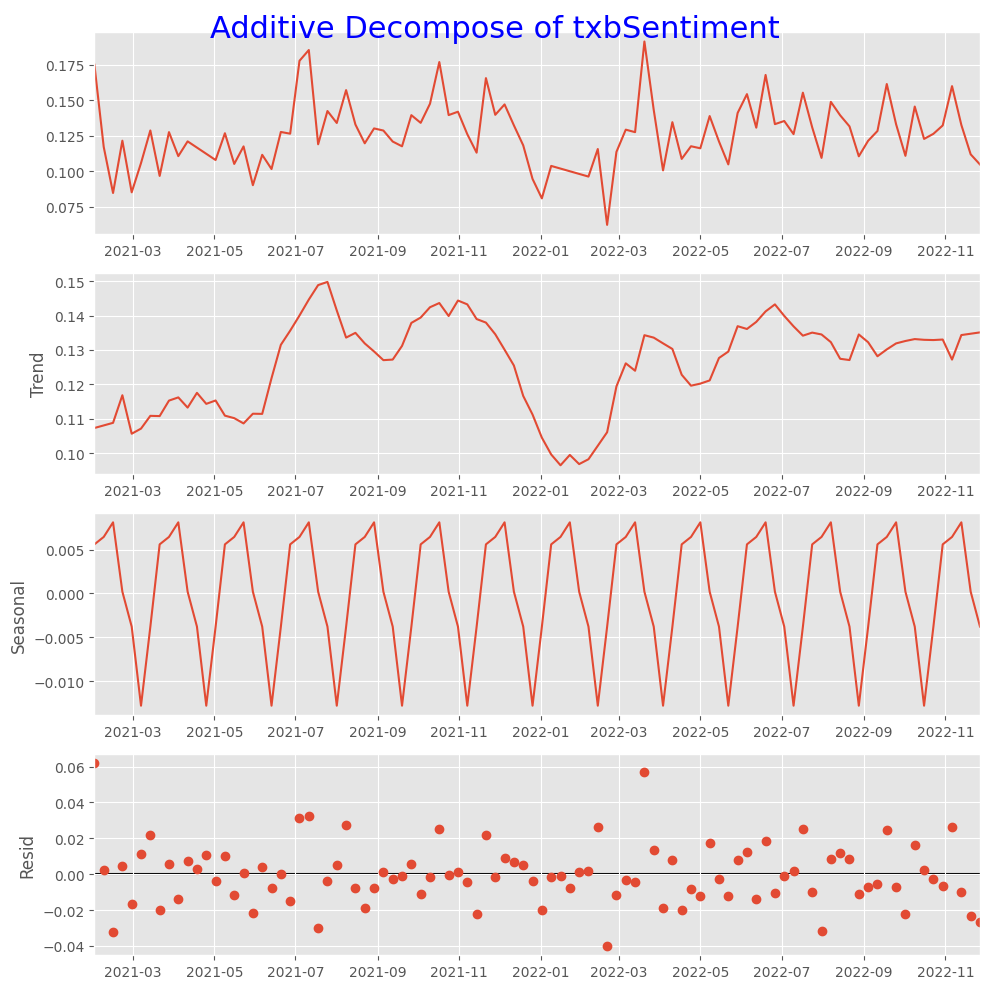

,seas,trend,resid,actual_values
date,,,,
2021-01-31 00:00:00+00:00,0.005592,0.107286,0.062122,0.175000
2021-02-07 00:00:00+00:00,0.006439,0.108037,0.002598,0.117075
2021-02-14 00:00:00+00:00,0.008101,0.108789,-0.032274,0.084615
2021-02-21 00:00:00+00:00,0.000207,0.116812,0.004470,0.121490
2021-02-28 00:00:00+00:00,-0.003770,0.105619,-0.016746,0.085103


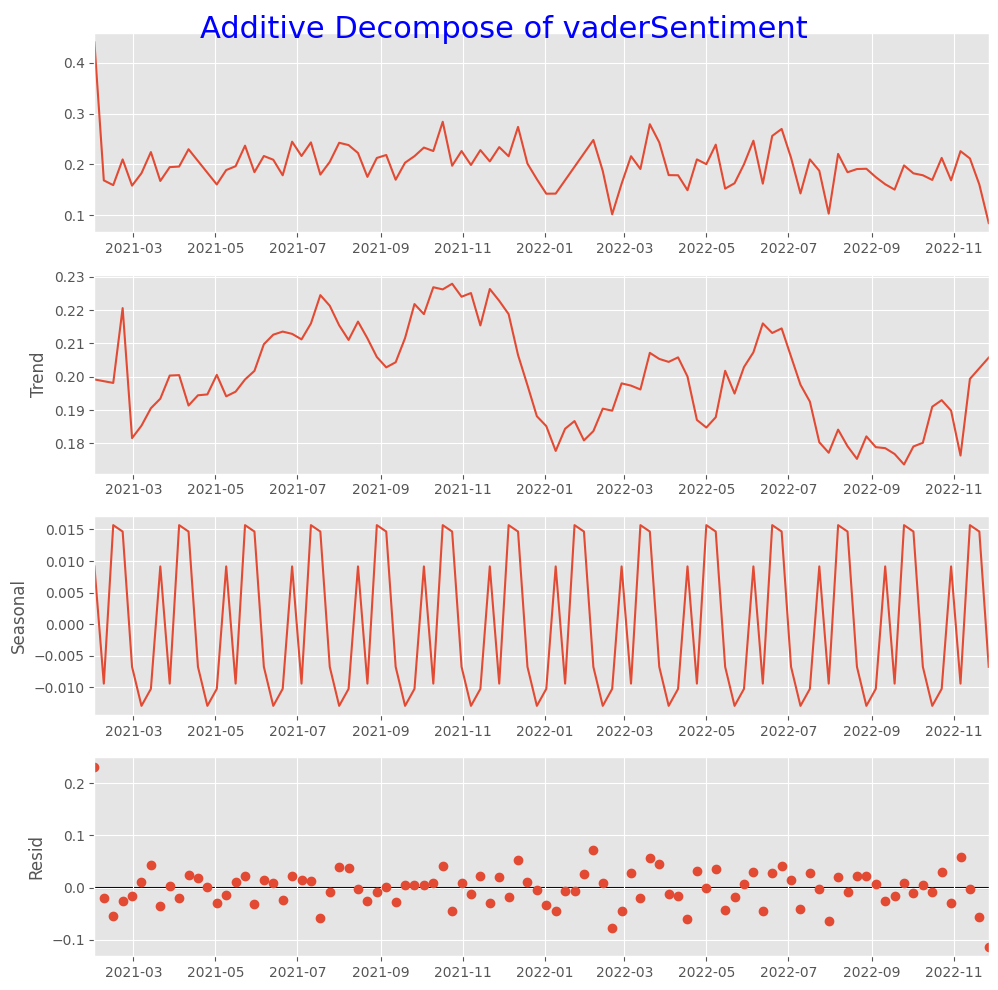

,seas,trend,resid,actual_values
date,,,,
2021-01-31 00:00:00+00:00,0.009143,0.199181,0.232076,0.440400
2021-02-07 00:00:00+00:00,-0.009454,0.198657,-0.020507,0.168695
2021-02-14 00:00:00+00:00,0.015691,0.198132,-0.054506,0.159317
2021-02-21 00:00:00+00:00,0.014673,0.220568,-0.025261,0.209980
2021-02-28 00:00:00+00:00,-0.006787,0.181587,-0.016448,0.158353


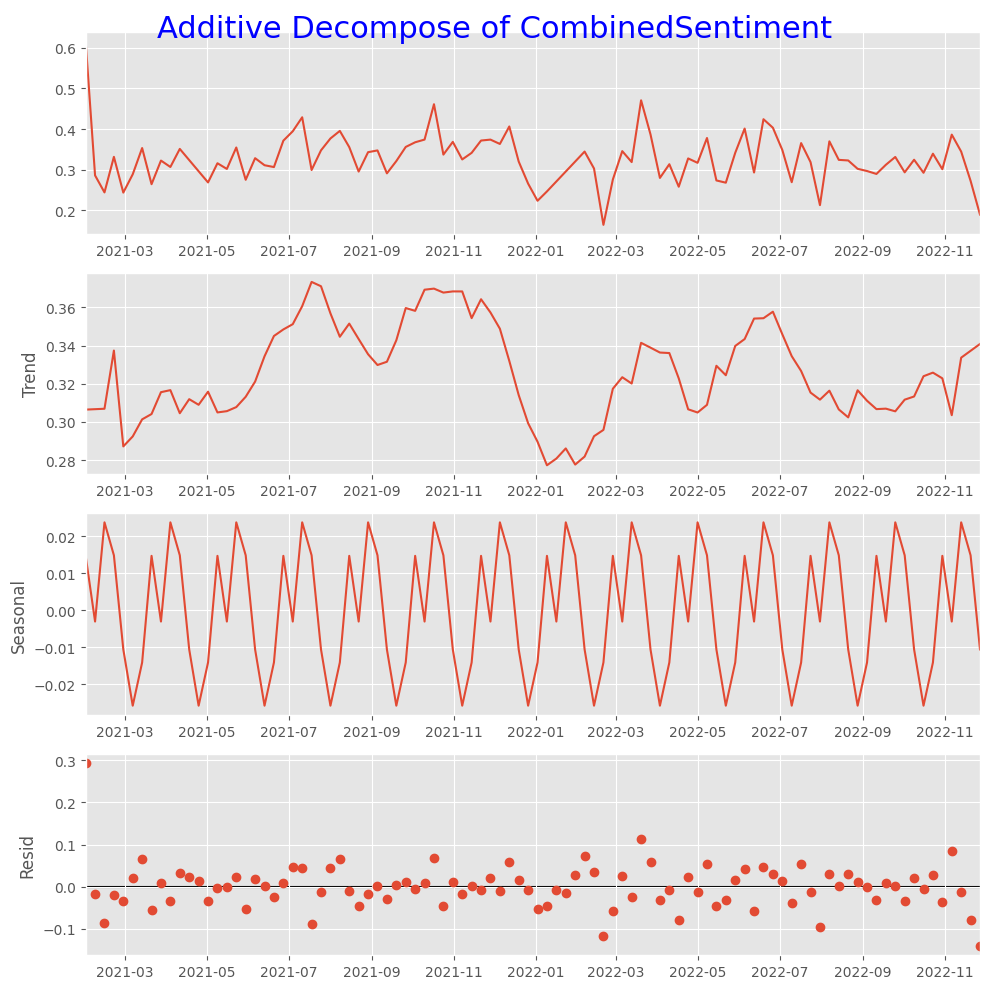

,seas,trend,resid,actual_values
date,,,,
2021-01-31 00:00:00+00:00,0.014735,0.306467,0.294198,0.615400
2021-02-07 00:00:00+00:00,-0.003015,0.306694,-0.017909,0.285770
2021-02-14 00:00:00+00:00,0.023792,0.306921,-0.086781,0.243932
2021-02-21 00:00:00+00:00,0.014880,0.337380,-0.020790,0.331470
2021-02-28 00:00:00+00:00,-0.010557,0.287206,-0.033194,0.243456


In [14]:
# function to display trends and seasonality
def plot_trend_seasonality(df, col):
    # Additive Decomposition
    result_add = seasonal_decompose(df[col], model='additive', extrapolate_trend='freq' , period=7)

    # Plot
    plt.rcParams.update({'figure.figsize': (10,10)})
    # result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
    # add the title to the plot
    
    result_add.plot().suptitle('Additive Decompose of ' + col, fontsize=22, color='blue')
    plt.show()
    # Extract the Components ----
    # Actual Values = Product of (Seasonal * Trend * Resid)
    df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
    df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
    display(df_reconstructed.head())



for i in ['txbSentiment', 'vaderSentiment', 'CombinedSentiment']:
    plot_trend_seasonality(df, i)

    
#df = df.set_index('date').asfreq('D')
# Multiplicative Decomposition  Multiplicative seasonality is not appropriate for zero and negative values
# result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')



Test for Stationary Seasonality using Augmented Dickey Fuller test (ADH Test)

In [15]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.txbSentiment.values)
print ("TextBlob Sentiment ADF Test")
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] > 0.05:
    print('Probably not Stationary')
else:
    print('Probably Stationary')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

result = adfuller(df.vaderSentiment.values)

print ("\n Vader Sentiment ADF Test")
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}') 
if result[1] > 0.05:
    print('Probably not Stationary')
else:
    print('Probably Stationary')

for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

result = adfuller(df.CombinedSentiment.values)

print ("\n Combined Sentiment ADF Test")
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}') 
if result[1] > 0.05:
    print('Probably not Stationary')
else:
    print('Probably Stationary')

for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

TextBlob Sentiment ADF Test
ADF Statistic: -6.863973307717687
p-value: 1.5763050593574846e-09
Probably Stationary
Critial Values:
   1%, -3.5011373281819504
Critial Values:
   5%, -2.8924800524857854
Critial Values:
   10%, -2.5832749307479226

 Vader Sentiment ADF Test
ADF Statistic: -2.412244689099504
p-value: 0.13831021826489986
Probably not Stationary
Critial Values:
   1%, -3.506057133647011
Critial Values:
   5%, -2.8946066061911946
Critial Values:
   10%, -2.5844100201994697

 Combined Sentiment ADF Test
ADF Statistic: -8.946784801222686
p-value: 8.943946703654746e-15
Probably Stationary
Critial Values:
   1%, -3.5011373281819504
Critial Values:
   5%, -2.8924800524857854
Critial Values:
   10%, -2.5832749307479226


No trend is visible in the previous charts in this data

lets check for seasonality 

In [16]:

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


def plot_acf_pacf(df, col):
    # Calculate ACF and PACF upto 50 lags
    # acf_50 = acf(df.value, nlags=50)
    # pacf_50 = pacf(df.value, nlags=50)

    # Draw Plot
    fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
    # titles
    axes[0].set_title('Autocorrelation ' + col, color='blue')
    plot_acf(df[col].tolist(), lags=40, ax=axes[0])
    axes[1].set_title('Partial Autocorrelation ' + col, color='blue')
    plot_pacf(df[col].tolist(), lags=40, ax=axes[1], method='ywm')

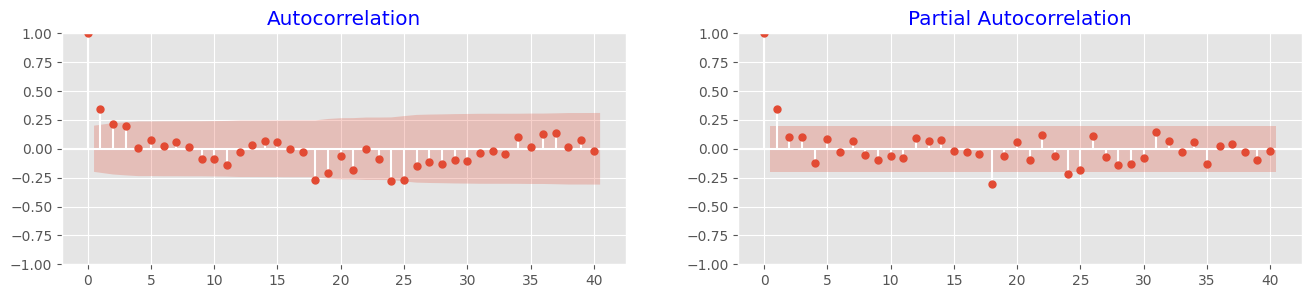

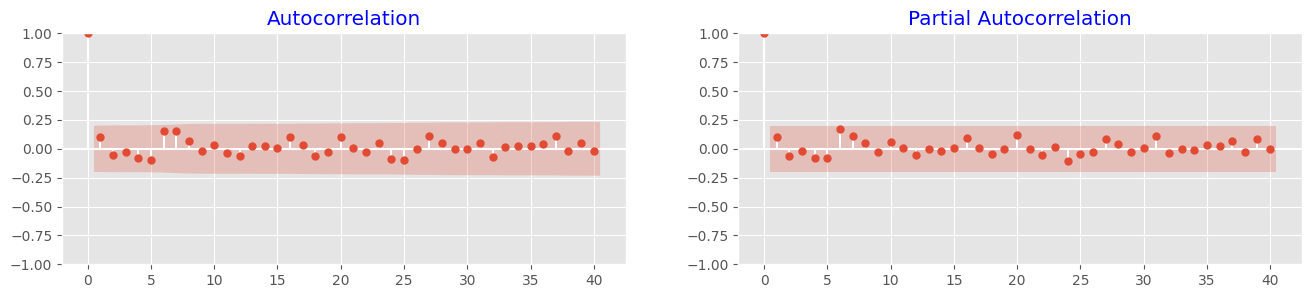

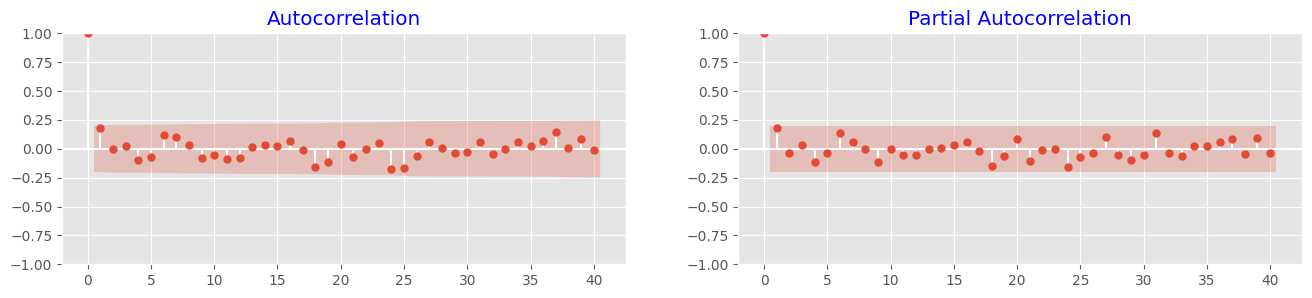

In [17]:
for i in ['txbSentiment', 'vaderSentiment', 'CombinedSentiment']:
    plot_acf_pacf(df, i)

Scatter plots showing the lag correlation

In [18]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

def plot_lag(df, col):
    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
    for i, ax in enumerate(axes.flatten()[:4]):
        lag_plot(df[col], lag=i+1, ax=ax, c='firebrick')
        ax.set_title('Lag ' + str(i+1) , color='blue')
        

    fig.suptitle('Lag Plots of Tweet Sentiment ' + col + '\n(Wider more scattered points -> lesser correlation)\n', y=1.15, color='blue')
    plt.show()

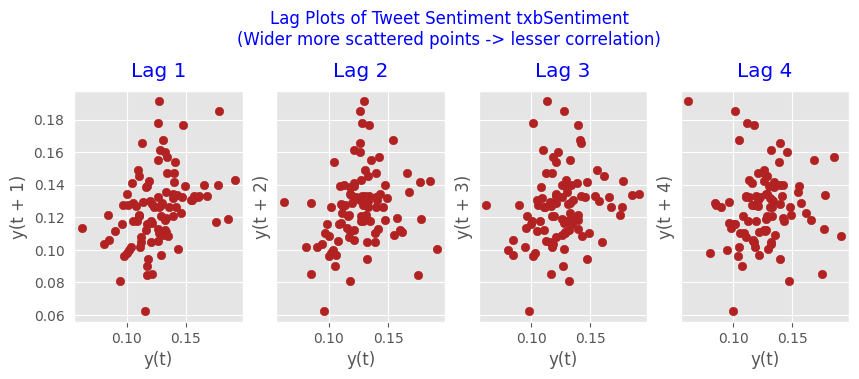

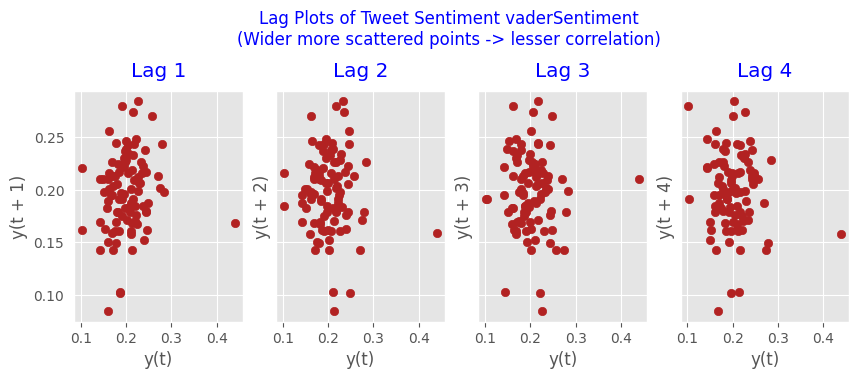

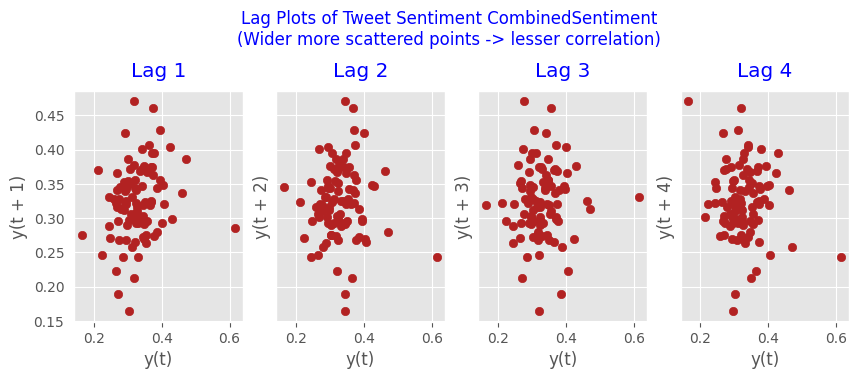

In [19]:
for i in ['txbSentiment', 'vaderSentiment', 'CombinedSentiment']:
    plot_lag(df, i)

Entropy 

In [20]:
import numpy as np
rand_small = np.random.randint(0, 100, size=48)
rand_big = np.random.randint(0, 100, size=96)

def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))



In [21]:
print(SampEn(df.txbSentiment, m=2, r=0.2*np.std(df.txbSentiment)))  

print(SampEn(rand_small, m=2, r=0.2*np.std(rand_small)))  
print(SampEn(rand_big, m=2, r=0.2*np.std(rand_big)))      

1.488077055429833
inf
1.791759469228055


C:\Users\stehayes\AppData\Local\Temp\ipykernel_6808\3832917519.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(_phi(m+1) / _phi(m))


Granger Causality 

In [22]:
from statsmodels.tsa.stattools import grangercausalitytests

# got an error when trying to use the date, as it was the index
df = df.reset_index()

df['month'] = df.date.dt.month
grangercausalitytests(df[['txbSentiment', 'month']], maxlag=4)




Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9300  , p=0.0289  , df_denom=92, df_num=1
ssr based chi2 test:   chi2=5.0907  , p=0.0241  , df=1
likelihood ratio test: chi2=4.9590  , p=0.0260  , df=1
parameter F test:         F=4.9300  , p=0.0289  , df_denom=92, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4996  , p=0.2288  , df_denom=89, df_num=2
ssr based chi2 test:   chi2=3.1676  , p=0.2052  , df=2
likelihood ratio test: chi2=3.1154  , p=0.2106  , df=2
parameter F test:         F=1.4996  , p=0.2288  , df_denom=89, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5518  , p=0.6483  , df_denom=86, df_num=3
ssr based chi2 test:   chi2=1.7901  , p=0.6171  , df=3
likelihood ratio test: chi2=1.7731  , p=0.6208  , df=3
parameter F test:         F=0.5518  , p=0.6483  , df_denom=86, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6273  , p=0.6444  , df_d

{1: ({'ssr_ftest': (4.929987653356328, 0.02885039810757516, 92.0, 1),
   'ssr_chi2test': (5.090748120313599, 0.0240538128917835, 1),
   'lrtest': (4.959034587463066, 0.0259546936522358, 1),
   'params_ftest': (4.929987653356352, 0.028850398107574962, 92.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.4995557344676727, 0.2288145463223118, 89.0, 2),
   'ssr_chi2test': (3.1676008773024997, 0.2051937880814598, 2),
   'lrtest': (3.115399636447364, 0.2106199786865216, 2),
   'params_ftest': (1.4995557344678077, 0.2288145463222811, 89.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.5517894209586481, 0.6483064531077862, 86.0, 3),
   'ssr_chi2test': (1.790107540086777, 0.6170900085278872, 3),
   'lrtest': (1.7730970632437675, 0.6208067413189824, 3),
   'params_ftest': (0.5517894209587073, 0.6483064531077445, 86.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1

In [23]:
df['week'] = df.date.dt.week
grangercausalitytests(df[['txbSentiment', 'week']], maxlag=4)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6819  , p=0.0581  , df_denom=92, df_num=1
ssr based chi2 test:   chi2=3.8019  , p=0.0512  , df=1
likelihood ratio test: chi2=3.7278  , p=0.0535  , df=1
parameter F test:         F=3.6819  , p=0.0581  , df_denom=92, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1017  , p=0.3368  , df_denom=89, df_num=2
ssr based chi2 test:   chi2=2.3271  , p=0.3124  , df=2
likelihood ratio test: chi2=2.2988  , p=0.3168  , df=2
parameter F test:         F=1.1017  , p=0.3368  , df_denom=89, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3143  , p=0.8150  , df_denom=86, df_num=3
ssr based chi2 test:   chi2=1.0196  , p=0.7965  , df=3
likelihood ratio test: chi2=1.0140  , p=0.7979  , df=3
parameter F test:         F=0.3143  , p=0.8150  , df_denom=86, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7039  , p=0.5915  , df_d

C:\Users\stehayes\AppData\Local\Temp\ipykernel_6808\4239364594.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df.date.dt.week


{1: ({'ssr_ftest': (3.681866527446436, 0.05810733070134186, 92.0, 1),
   'ssr_chi2test': (3.8019273924718635, 0.05119362188829384, 1),
   'lrtest': (3.7278209934772804, 0.05351316152796347, 1),
   'params_ftest': (3.6818665274446922, 0.05810733070140039, 92.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.1016812211661882, 0.33680030125865396, 89.0, 2),
   'ssr_chi2test': (2.327146849204982, 0.3123679607788265, 2),
   'lrtest': (2.2988071820506093, 0.31682567071565626, 2),
   'params_ftest': (1.1016812211665714, 0.33680030125852845, 89.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.3142755436938981, 0.8150122905797732, 86.0, 3),
   'ssr_chi2test': (1.0195683336115997, 0.7965171426667126, 3),
   'lrtest': (1.0140200328482933, 0.7978595745765207, 3),
   'params_ftest': (0.31427554369380173, 0.815012290579846, 86.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0

Predicting Sentiment at last!

In [24]:
import pandas as pd 
import pandas_datareader as web 
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

In [25]:
#split the data into train and training set
#(df['date'].max() - df['date'].min()) *0.7
df_old = df.copy()
# dropping columns that have proved to be problematic
df = df.drop(['vaderSentiment', 'week', 'month', 'CombinedSentiment'], axis=1)

train = df[df['date'] < df['date'].min() + (df['date'].max() - df['date'].min()) *0.7]
test = df[df['date'] >= df['date'].min() + (df['date'].max() - df['date'].min()) *0.7]

train['date'] = pd.to_datetime(train['date']) # making sure the date is in the right format
train = train.set_index('date')

test['date'] = pd.to_datetime(test['date']) # making sure the date is in the right format
test = test.set_index('date')


C:\Users\stehayes\AppData\Local\Temp\ipykernel_6808\479954875.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['date'] = pd.to_datetime(train['date']) # making sure the date is in the right format
C:\Users\stehayes\AppData\Local\Temp\ipykernel_6808\479954875.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date'] = pd.to_datetime(test['date']) # making sure the date is in the right format


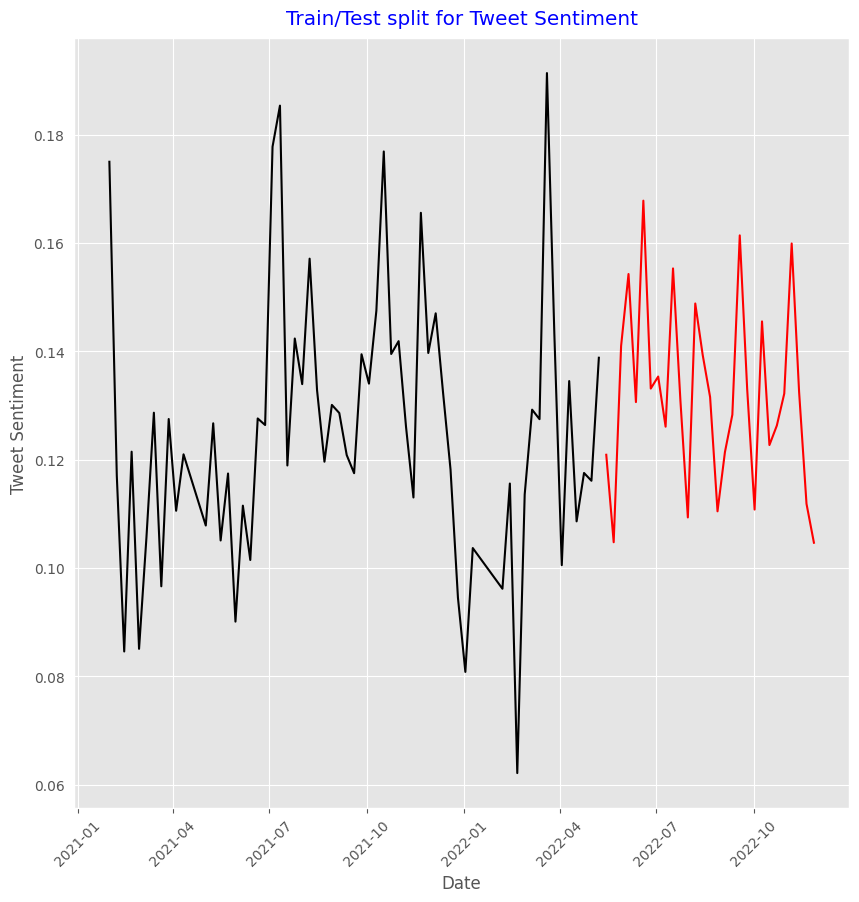

In [26]:
plt.plot(train['txbSentiment'], color = "black", label = 'Training')
plt.plot(test['txbSentiment'], color = "red", label = 'Testing')
plt.ylabel('Tweet Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Tweet Sentiment", color = "blue")
plt.show()

y = train['txbSentiment']


## Evaluation Phase 

### Grid Search for the best model

Taken from here https://towardsdev.com/auto-arima-hyperparameter-search-ab991a21c2bd

In [27]:
import itertools
import warnings
warnings.filterwarnings('ignore')
# Grid Search
p = d = q = range(0,3) # p, d, and q can be either 0, 1, or 2
pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q 
ARMA_pdq = [x for x in pdq if x[1] == 0] # since ARMA models don't have a differencing term, we only want the combinations where d = 0
p2 = d2 = q2 = range(0, 6) # second set of p's, d's, and q's for seasonal parameters
s = 12 

pdq2 = list(itertools.product(p2,d2,q2)) # similar to code above but for seasonal parameters

pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2]


In [28]:
# Grid search continued for ARMA
ARMA_combs = {}
ARMA_rmseDict = {}
ARMA_aics = []
ARMA_rmses = []

for combination in ARMA_pdq:
    try:
        ARMAmodel = SARIMAX(y, order = combination)
        ARMAmodel = ARMAmodel.fit(disp=False)
        ARMA_combs.update({ARMAmodel.aic : [combination]})
        ARMA_aics.append(ARMAmodel.aic)
        ARMA_rmseDict.update({np.sqrt(ARMAmodel.mse): [combination]})
        ARMA_rmses.append(np.sqrt(ARMAmodel.mse))
        #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(combination, seasonal_combination, model.aic))
           
    except:
        continue
            
ARMA_best_aic = min(ARMA_aics)
display(ARMA_best_aic)
display(ARMA_combs[ARMA_best_aic])
ARMA_best_rmse = min(ARMA_rmses)
display(ARMA_best_rmse)
display(ARMA_rmseDict[ARMA_best_rmse])
        

-301.17679461092507

[(2, 0, 1)]

0.031672380658061355

[(2, 0, 1)]

In [29]:
# Grid search continued for ARIMAmodel
ARIMA_combs = {}
ARIMA_rmseDict = {}
ARIMA_aics = []
ARIMA_rmses = []
for combination in pdq:
    try:
        ARIMAmodel = SARIMAX(y, order = combination)
        ARIMAmodel = ARIMAmodel.fit(disp=False)
        ARIMA_combs.update({ARIMAmodel.aic : [combination]})
        ARIMA_aics.append(ARIMAmodel.aic)
        ARIMA_rmseDict.update({np.sqrt(ARIMAmodel.mse): [combination]})
        ARIMA_rmses.append(np.sqrt(ARIMAmodel.mse))
        #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(combination, seasonal_combination, model.aic))
           
    except:
        continue
            
ARIMA_best_aic = min(ARIMA_aics)
display(ARIMA_best_aic)
display(ARIMA_combs[ARIMA_best_aic])
ARIMA_best_rmse = min(ARIMA_rmses)
display(ARIMA_best_rmse)
display(ARIMA_rmseDict[ARIMA_best_rmse])
        

-301.8545201327202

[(1, 1, 1)]

0.031672380658061355

[(2, 0, 1)]

In [30]:
""" # Grid Search Continued for SARIMAX
SARIMAX_combs = {}
SARIMAX_rmseDict = {}
SARIMAX_aics = []
SARIMAX_rmses = []
for combination in pdq:
    for seasonal_combination in pdqs2:
        try:
            SARIMAXmodel = SARIMAX(y, order=combination, seasonal_order=seasonal_combination)
            SARIMAXmodel = SARIMAXmodel.fit(disp=False)
            SARIMAX_combs.update({SARIMAXmodel.aic : [combination, seasonal_combination]})
            SARIMAX_aics.append(SARIMAXmodel.aic)
            SARIMAX_rmseDict.update({np.sqrt(SARIMAXmodel.mse): [combination, seasonal_combination]})
            SARIMAX_rmses.append(np.sqrt(SARIMAXmodel.mse))
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(combination, seasonal_combination, model.aic))
            
        except:
            continue
            
SARIMAX_best_aic = min(SARIMAX_aics)
display(SARIMAX_best_aic)
display(SARIMAX_combs[SARIMAX_best_aic])
SARIMAX_best_rmse = min(SARIMAX_rmses)
display(SARIMAX_best_rmse)
display(SARIMAX_rmseDict[SARIMAX_best_rmse]) """

" # Grid Search Continued for SARIMAX\nSARIMAX_combs = {}\nSARIMAX_rmseDict = {}\nSARIMAX_aics = []\nSARIMAX_rmses = []\nfor combination in pdq:\n    for seasonal_combination in pdqs2:\n        try:\n            SARIMAXmodel = SARIMAX(y, order=combination, seasonal_order=seasonal_combination)\n            SARIMAXmodel = SARIMAXmodel.fit(disp=False)\n            SARIMAX_combs.update({SARIMAXmodel.aic : [combination, seasonal_combination]})\n            SARIMAX_aics.append(SARIMAXmodel.aic)\n            SARIMAX_rmseDict.update({np.sqrt(SARIMAXmodel.mse): [combination, seasonal_combination]})\n            SARIMAX_rmses.append(np.sqrt(SARIMAXmodel.mse))\n            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(combination, seasonal_combination, model.aic))\n            \n        except:\n            continue\n            \nSARIMAX_best_aic = min(SARIMAX_aics)\ndisplay(SARIMAX_best_aic)\ndisplay(SARIMAX_combs[SARIMAX_best_aic])\nSARIMAX_best_rmse = min(SARIMAX_rmses)\ndisplay(SARIMA

### Arma

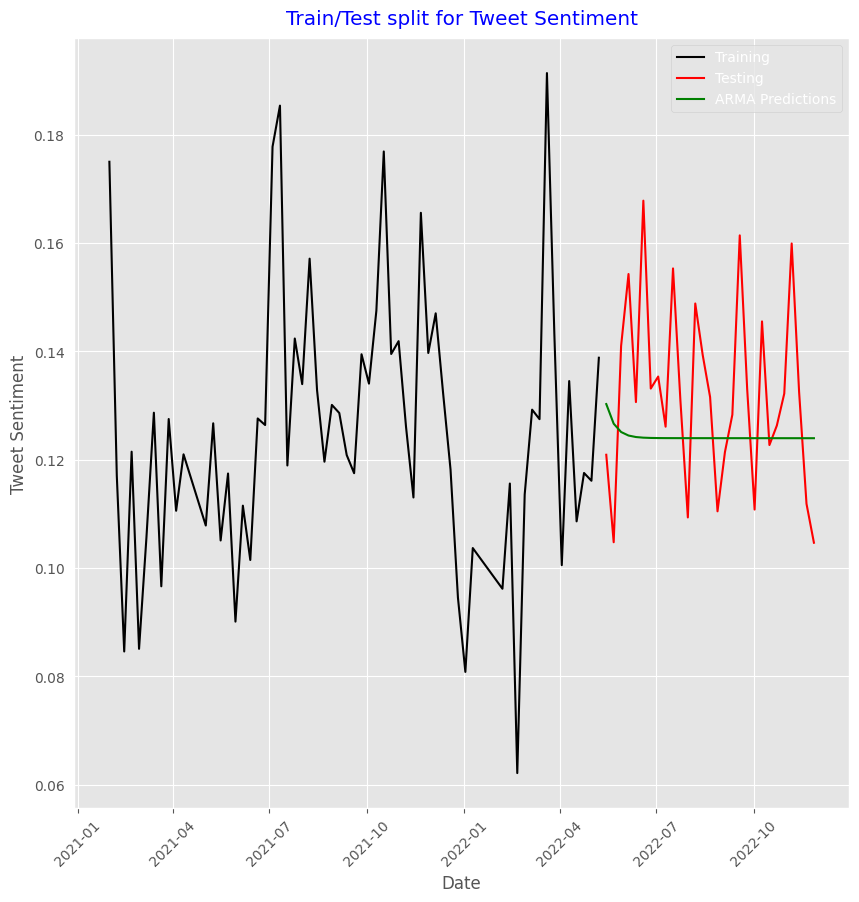

RMSE for ARMA model:  0.031672380658061355


In [31]:


ARMAmodel = SARIMAX(y, order = (2, 0, 1))
ARMAmodel = ARMAmodel.fit()

y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], 
                                             end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_outARMA = y_pred_df["Predictions"] 

plt.plot(train['txbSentiment'], color = "black", label = 'Training')
plt.plot(test['txbSentiment'], color = "red", label = 'Testing')
plt.ylabel('Tweet Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Tweet Sentiment", color = "blue")
plt.plot(y_pred_outARMA, color='green', label = 'ARMA Predictions')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(ARMAmodel.mse)
print("RMSE for ARMA model: ", arma_rmse)

### Arima

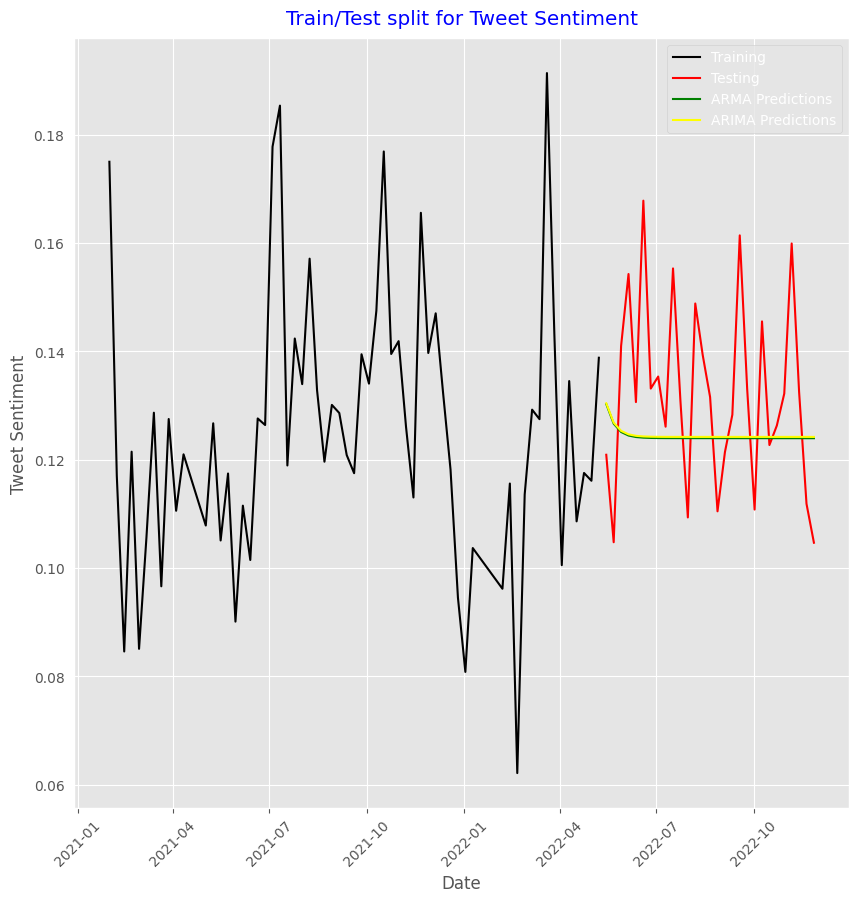

ARIMA RMSE:  0.03185068818081811


In [32]:
y = train['txbSentiment']

ARIMAmodel = SARIMAX(y, order = (1, 1, 1))
#ARIMAmodel = SARIMAX(y, order = (2, 3, 2))
#ARIMAmodel = SARIMAX(y, order = (5, 4, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0],
                                              end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_outARIMA = y_pred_df["Predictions"]

plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('Tweet Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Tweet Sentiment", color = "blue")
plt.plot(y_pred_outARMA, color='green', label = 'ARMA Predictions')
plt.plot(y_pred_outARIMA, color='Yellow', label = 'ARIMA Predictions')
plt.legend()
plt.show()

arima_rmse = np.sqrt(ARIMAmodel.mse)
print("ARIMA RMSE: ",arima_rmse)

 ### Sarima

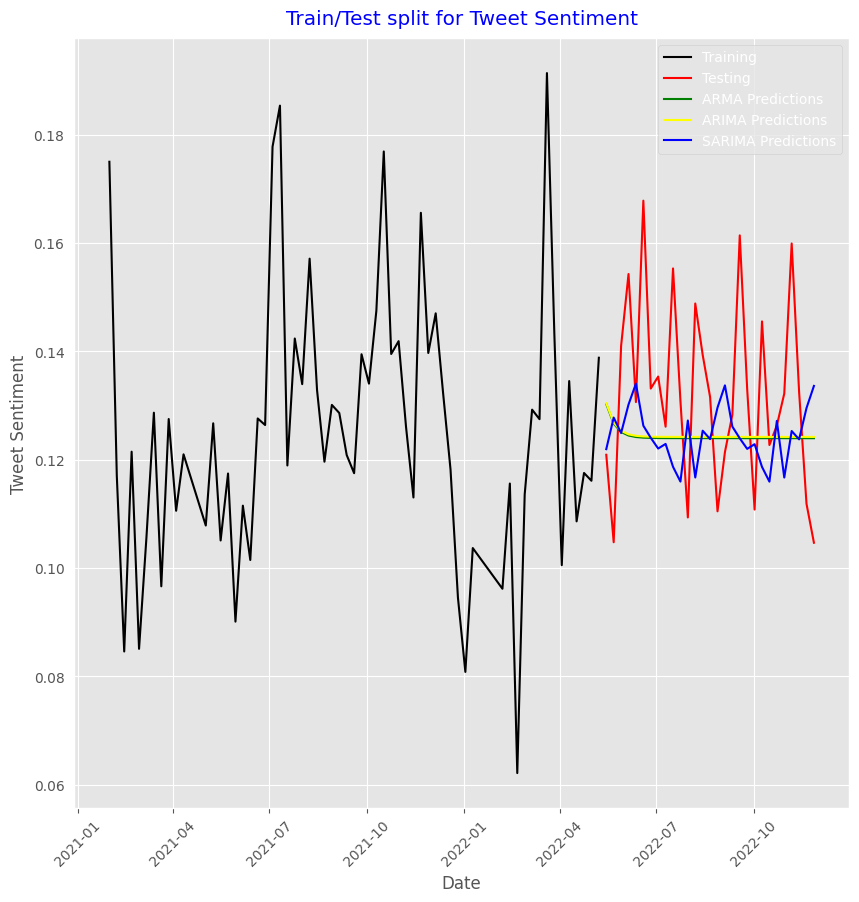

SARIMA RMSE:  0.031421142238327336


In [33]:
SARIMAXmodel = SARIMAX(y, order = (2,0,1), seasonal_order=(1, 0, 1, 12))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0],
                                                end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_outSARIMAX = y_pred_df["Predictions"] 
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('Tweet Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Tweet Sentiment", color = "blue")
plt.plot(y_pred_outARMA, color='green', label = 'ARMA Predictions')
plt.plot(y_pred_outARIMA, color='Yellow', label = 'ARIMA Predictions')
plt.plot(y_pred_outSARIMAX, color='Blue', label = 'SARIMA Predictions')
plt.legend()
plt.show()

sarima_rmse = np.sqrt(SARIMAXmodel.mse)
print("SARIMA RMSE: ",sarima_rmse)

## Deployment Phase

### SARIMAX model wins the right predict txbSentiment

In [34]:
# Updat the model with all of the data 
dfSentiment = pd.concat([train, test], axis = 0)
y = dfSentiment['txbSentiment'] 

SARIMAXmodel = SARIMAX(y, order = (2,0,1), seasonal_order=(1, 0, 1, 12))
SARIMAXmodel = SARIMAXmodel.fit()

In [35]:
week1 = SARIMAXmodel.predict(start = len(dfSentiment)-1, end = len(dfSentiment)) #.conf_int(alpha = 0.01)
week4 = SARIMAXmodel.predict(start = len(dfSentiment), end = len(dfSentiment) + 4) #.conf_int(alpha = 0.01)
week12 = SARIMAXmodel.predict(start = len(dfSentiment), end = len(dfSentiment) + 12) #.conf_int(alpha = 0.01)

In [36]:
display(week1)
display(week4)
display(week12)

2022-11-27 00:00:00+00:00    0.123334
2022-12-04 00:00:00+00:00    0.118581
Freq: W-SUN, Name: predicted_mean, dtype: float64

2022-12-04 00:00:00+00:00    0.118581
2022-12-11 00:00:00+00:00    0.122683
2022-12-18 00:00:00+00:00    0.124055
2022-12-25 00:00:00+00:00    0.124391
2023-01-01 00:00:00+00:00    0.124283
Freq: W-SUN, Name: predicted_mean, dtype: float64

2022-12-04 00:00:00+00:00    0.118581
2022-12-11 00:00:00+00:00    0.122683
2022-12-18 00:00:00+00:00    0.124055
2022-12-25 00:00:00+00:00    0.124391
2023-01-01 00:00:00+00:00    0.124283
2023-01-08 00:00:00+00:00    0.124678
2023-01-15 00:00:00+00:00    0.123761
2023-01-22 00:00:00+00:00    0.124175
2023-01-29 00:00:00+00:00    0.123371
2023-02-05 00:00:00+00:00    0.123335
2023-02-12 00:00:00+00:00    0.122954
2023-02-19 00:00:00+00:00    0.122635
2023-02-26 00:00:00+00:00    0.122628
Freq: W-SUN, Name: predicted_mean, dtype: float64

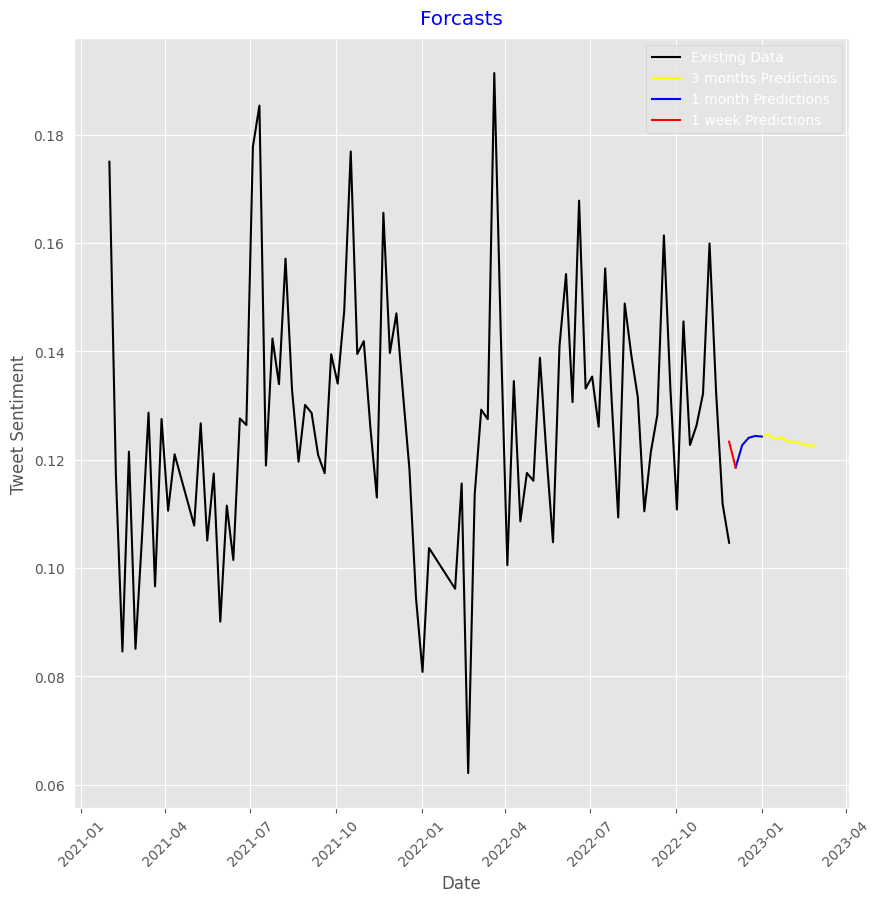

In [37]:
plt.plot(dfSentiment, color = "black", label = 'Existing Data')
plt.ylabel('Tweet Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Forcasts", color = "blue")

plt.plot(week12, color='Yellow', label = '3 months Predictions')
plt.plot(week4, color='Blue', label = '1 month Predictions')
plt.plot(week1, color='red', label = '1 week Predictions')
plt.legend()
plt.show()

In [38]:
week12 = pd.DataFrame(week12)

week12.reset_index(inplace = True)

In [39]:
week12.head()

,index,predicted_mean
0,2022-12-04 00:00:00+00:00,0.118581
1,2022-12-11 00:00:00+00:00,0.122683
2,2022-12-18 00:00:00+00:00,0.124055
3,2022-12-25 00:00:00+00:00,0.124391
4,2023-01-01 00:00:00+00:00,0.124283


In [40]:
# Rename column 'index' to 'date'
week12 = week12.rename(columns={'index': 'date'})
# Rename column 'predicted_mean' to 'txbSentiment'
week12 = week12.rename(columns={'predicted_mean': 'txbSentiment'})


week12.head()

,date,txbSentiment
0,2022-12-04 00:00:00+00:00,0.118581
1,2022-12-11 00:00:00+00:00,0.122683
2,2022-12-18 00:00:00+00:00,0.124055
3,2022-12-25 00:00:00+00:00,0.124391
4,2023-01-01 00:00:00+00:00,0.124283


In [41]:
df.head()

,date,txbSentiment
0,2021-01-31 00:00:00+00:00,0.175000
1,2021-02-07 00:00:00+00:00,0.117075
2,2021-02-14 00:00:00+00:00,0.084615
3,2021-02-21 00:00:00+00:00,0.121490
4,2021-02-28 00:00:00+00:00,0.085103


In [42]:
dfSentiment = df.append( week12, ignore_index = True)



In [43]:
dfSentiment.head()

,date,txbSentiment
0,2021-01-31 00:00:00+00:00,0.175000
1,2021-02-07 00:00:00+00:00,0.117075
2,2021-02-14 00:00:00+00:00,0.084615
3,2021-02-21 00:00:00+00:00,0.121490
4,2021-02-28 00:00:00+00:00,0.085103


In [44]:
dfSentiment.to_csv("./Data/dfSentiment.csv")

# Dashboard

In [45]:
import panel as pn
import pandas as pd
import bokeh as bk

pn.extension(size_policy='stretch_width', design='material', template = 'fast')
pn.state.template.param.update(title = "Tweet Sentiment Analysis")

forecast = pn.widgets.Select(name='Forecast', options=['none', '1 week', '1 month', '3 months'])

In [46]:
twtsent = pd.read_csv("./Data/TweetInfo.csv")
dfSent = pd.read_csv("./Data/dfSentiment.csv")
start_date = "2021-01-31"
end_date = "2022-11-27"
mask = (dfSent["date"] >= start_date) & (dfSent["date"] <= end_date)
df_original = dfSent.loc[mask]

end_date = "2022-12-11"
mask = (dfSent["date"] >= start_date) & (dfSent["date"] <= end_date)
df_1week = dfSent.loc[mask]

end_date = "2022-12-28"
mask = (dfSent["date"] >= start_date) & (dfSent["date"] <= end_date)
df_1month = dfSent.loc[mask]

def ret_Data(forecast):
    if forecast == "none":
        return df_original[['date','txbSentiment']].sort_values(by=['date'], ascending = False)
    elif forecast == "1 week":
        return df_1week[['date','txbSentiment']].sort_values(by=['date'], ascending = False)
    elif forecast == "1 month":
        return df_1month[['date','txbSentiment']].sort_values(by=['date'], ascending = False)
    elif forecast == "3 months":
        return  dfSent[['date','txbSentiment']].sort_values(by=['date'], ascending = False)


In [47]:


pn.Row(
    pn.Row(
        pn.Column("Number of tweets: ",len(twtsent["id"])),
        pn.Column("Number of tweets by Likert Scale: \n", twtsent["LikertScale"].value_counts()),
        pn.Column(forecast).servable()
    ),
    pn.Row(
        pn.bind(ret_Data, forecast),
    ).servable(),
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'21cf22a5-053d-4b4c-b3bf-e595f7303029': {'version…